<a href="https://colab.research.google.com/github/anthony-hung-do/arctic-tilt/blob/main/experiments/Arctic_TILT_on_DocVQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Describe

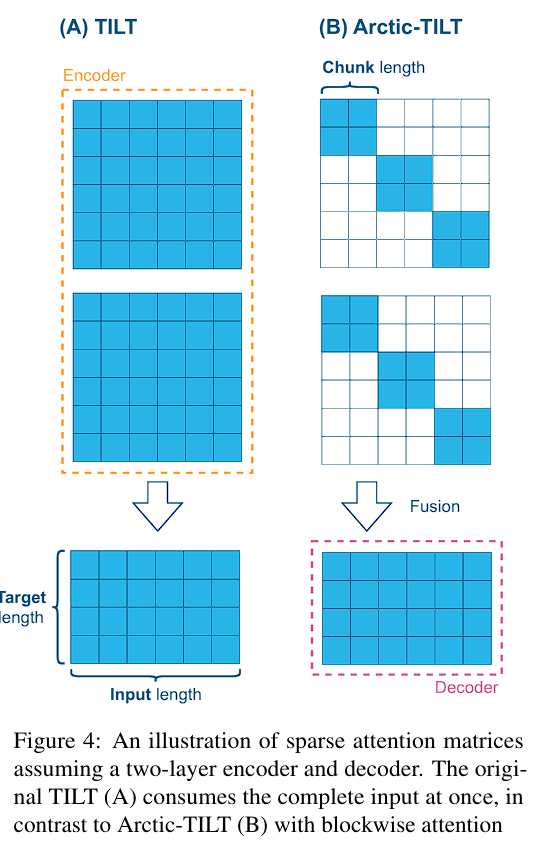

In this part, I will do 2 things:
1. I will apply SLED with a core chunk length of 1024 and no overlap. Then, the resulting sequences are passed through the encoder separately. The encoder outputs are then recombined by removing the prefix tokens embeddings from all but the first chunk and concatenating the results. The resulting encoder output is passed to the decoder.
2. Apply sparse attention matrices

In [1]:
!pip install -qqq wandb

In [2]:
from google.colab import userdata
import wandb

wandb_token = userdata.get('wandb_api')
wandb.login(key=wandb_token)

try:
    user = wandb.api.viewer()
    print("✅ Đã đăng nhập thành công với Weights & Biases!")
    print("Tên tài khoản:", user.get('username', 'Không xác định'))
except Exception as e:
    print("❌ Chưa đăng nhập hoặc token không hợp lệ.")
    print("Lỗi:", e)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: xuanlinh-work (xuanlinh-work-dut) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ Đã đăng nhập thành công với Weights & Biases!
Tên tài khoản: xuanlinh-work


In [3]:
!pip install -qqq datasets huggingface_hub fsspec sentencepiece pytorch_lightning seqeval evaluate transformers==4.37.2
!pip install -qqq --upgrade datasets huggingface_hub fsspec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.2/828.2 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 33.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.2 which is incompatible.


In [4]:
from google.colab import userdata
from huggingface_hub import login
from huggingface_hub import whoami

hf_token = userdata.get('HF_TOKEN')
login(hf_token)

try:
    info = whoami()
    print("✅ Đã đăng nhập thành công với Hugging Face!")
    print("Tên tài khoản:", info["name"])
    print("Vai trò:", info.get("type", "Không xác định"))
except Exception as e:
    print("❌ Chưa đăng nhập hoặc token không hợp lệ.")
    print("Lỗi:", e)


✅ Đã đăng nhập thành công với Hugging Face!
Tên tài khoản: xlinh
Vai trò: user


In [5]:
import os
from transformers import AutoTokenizer, AutoConfig
from datasets import load_dataset, DatasetDict
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from pytorch_lightning.loggers import CSVLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as pl

from torchvision import transforms
from tqdm.auto import tqdm

## Custom imports
from transformers import AutoModel

## 1.1. Preparing the dataset

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

hf_ds = load_dataset("nielsr/docvqa_1200_examples")
docvqa_dataset = DatasetDict({
    'train': hf_ds['train'].train_test_split(test_size=0.9, seed=42)['train'],
    'test': hf_ds['test'].train_test_split(test_size=0.9, seed=42)['train']
})
model_name = "t5-base"
## Visual Embedding extractor's parameters
in_channels = 3
num_pool_layers = 3
channels = 16
sampling_ratio = 2
spatial_scale = 48 / 384
output_size = (3,3)
load_weights = True
max_epochs = 3

## Tokenizer's parameter
model_max_length = 512
max_target_length = 128

t5_config_docvqa = AutoConfig.from_pretrained(model_name)
## Adding new parameters for Arctic-TILT
t5_config_docvqa.update(dict(
    dropout_rate = 0.1,
    in_channels = in_channels,
    num_pool_layers = num_pool_layers,
    channels = channels,
    model_max_length = model_max_length,
    max_target_length = max_target_length,
    output_size = output_size,
    spatial_scale = spatial_scale,
    sampling_ratio = sampling_ratio,
    use_cache = False,
    load_weights = load_weights,
    lr =  2e-4,
    max_epochs = max_epochs,
    # Arctic-TILT parameters
    use_post_fusion = True,
    fusion_dropout = 0.1,
    core_chunk_length = 512,
    chunk_overlap = 0,
    use_chunked_processing = True,
    task_type = "document_qa"
))

# t5_config_docvqa._name_or_path = model_name

dataset_infos.json: 0.00B [00:00, ?B/s]

(…)-00000-of-00001-f795527aa19f0f90.parquet:   0%|          | 0.00/123M [00:00<?, ?B/s]

(…)-00000-of-00001-41a63b2e1b4ecc5e.parquet:   0%|          | 0.00/25.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/200 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

## 1.2 DocVQADataset

I removed the truncation since the chunkedProcessor already handles it, and removed the fixed padding so that collate_fn can handle dynamic padding.

In [7]:
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torch
from PIL import Image
import numpy as np

class DocVQADataset(Dataset):
    def __init__(self, ds, tokenizer, max_source_length=512, max_target_length=128,
                 resize_scale=(512, 384), transform=None, language='en'):
        self.ds = ds
        self.tokenizer = tokenizer
        self.max_source_length = max_source_length
        self.max_target_length = max_target_length
        self.resize_scale = resize_scale
        self.transform = transform if transform is not None else ToTensor()
        self.language = language

    def __len__(self):
        return len(self.ds)

    def normalize_bbox(self, bbox, width, height):
        """Chuẩn hóa bounding box về [0, 1000]"""
        return [
            int(1000 * (bbox[0] / width)),
            int(1000 * (bbox[1] / height)),
            int(1000 * (bbox[2] / width)),
            int(1000 * (bbox[3] / height)),
        ]

    def __getitem__(self, idx):
        item = self.ds[idx]

        # 1. Xử lý hình ảnh
        image = item['image']
        if image.mode != 'RGB':
            image = image.convert('RGB')

        original_width, original_height = image.size
        resized_image = image.copy().resize(self.resize_scale)
        img_tensor = self.transform(resized_image)

        # 2. Lấy text và bounding boxes từ OCR
        words = item['words']
        bboxes = item['bounding_boxes']

        # 3. Lấy câu hỏi
        question = item['query'][self.language]

        # 4. Lấy câu trả lời đầu tiên
        answers = item['answers']
        target_text = answers[0] if answers else ""

        # 5. Tạo input text: question + OCR text
        ocr_text = " ".join(words)
        input_text = f"question: {question} context: {ocr_text}"

        # Kiểm tra độ dài trước khi tokenize
        if len(input_text.split()) > 400:  # Giới hạn tổng số từ
            words_limit = input_text.split()[:400]
            input_text = " ".join(words_limit)

        # 6. Tokenize input
        source_encoding = self.tokenizer(
            input_text,
            max_length=self.max_source_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        # 7. Tokenize target (answer)
        target_encoding = self.tokenizer(
            target_text,
            max_length=self.max_target_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        labels = target_encoding['input_ids'].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        # 8. Chuẩn hóa bounding boxes
        normalized_bboxes = []
        for i, bbox in enumerate(bboxes):
            if i >= len(words):
                break
            norm_bbox = self.normalize_bbox(bbox, original_width, original_height)
            normalized_bboxes.append(norm_bbox)

        # 9. Tạo bounding boxes cho từng token
        # Tokenize words để lấy word_ids
        word_encoding = self.tokenizer(words, is_split_into_words=True, add_special_tokens=False)
        word_ids = word_encoding.word_ids()

        # Tạo bbox array cho sequence length
        sequence_length = source_encoding['input_ids'].shape[1]
        bbox_array = []

        for i in range(sequence_length):
            if i < len(word_ids) and word_ids[i] is not None and word_ids[i] < len(normalized_bboxes):
                bbox_array.append(normalized_bboxes[word_ids[i]])
            else:
                bbox_array.append([0, 0, 0, 0])  # Padding bbox

        return {
            'input_ids': source_encoding['input_ids'].squeeze(),
            'attention_mask': source_encoding['attention_mask'].squeeze(),
            'labels': labels,
            'bboxes': torch.tensor(bbox_array, dtype=torch.long),
            'pixel_values': img_tensor,
            'question': question,
            'answer': target_text,
            'doc_id': item['id']
        }

## 1.3. Fusion

Now, I’m temporarily trimming text_len or img_len to maintain size constraints. I’ll update this part later.

In [8]:
class TiltLayerNorm(nn.Module):
    """
    This is essentially the T5 modification of layer norm, referred to as RMS norm.

    Args:
        dim: the dimension of vectors to be normalized, i.e. the last dimension of
             the input tensor
        eps: small positive value added to computed second moment for numerical
             stability
    """
    def __init__(self, dim: int, eps: float = 1e-6) -> None:
        super().__init__()
        self.w = nn.Parameter(torch.ones(dim))
        self.eps = eps
        self.init_weights()

    def forward(self, inp: torch.Tensor) -> torch.Tensor:
        dtype = inp.dtype
        x = inp.to(torch.float32)
        squared_norm = x.pow(2).mean(dim=-1, keepdim=True)
        x = x * torch.rsqrt(squared_norm + self.eps)
        return self.w * x.to(dtype)

    def init_weights(self, factor: float = 1.0) -> None:
        self.w.data.fill_(factor * 1.0)

class TiltPostFusionModule(nn.Module):
    """
    Introduced in the Arctic-TILT paper.

    Args:
        d_model: dimension of input vectors
        dropout: probability of dropout applied to input embeddings
        layer_norm: the module responsible for input embeddings
    """

    def __init__(self, d_model: int, dropout: float, layer_norm: TiltLayerNorm):
        super().__init__()
        self.layer_norm = layer_norm
        self.to_v = nn.Linear(d_model, d_model, bias=False)
        self.to_out = nn.Linear(d_model, d_model, bias=False)
        self.to_r = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text_queries: torch.Tensor, image_queries: torch.Tensor) -> torch.Tensor:
        """
        Compute module’s forward pass.

        Args:
            text_queries (Tensor): Tensor representing the primary input in the
                                  fusion, which is text-based, or mixed.
            image_queries (Tensor): Tensor representing the secondary input in the
                                   fusion, which is image-based.
        """
        bs, text_len, d = text_queries.shape
        _, img_len, _ = image_queries.shape

        # Handle sequence length mismatch
        if text_len != img_len:
            min_len = min(text_len, img_len)
            text_queries = text_queries[:, :min_len, :]
            image_queries = image_queries[:, :min_len, :]
            print(f"⚠️  Emergency trim in PostFusion: text={text_len}, vision={img_len} -> {min_len}")

        bs, l, d = text_queries.shape
        inputs = torch.stack([text_queries, image_queries], dim=-2)
        inputs = inputs.view(bs * l, 2, d)
        normed_inputs = self.dropout(self.layer_norm(inputs))
        normed_primary_input = normed_inputs[:, 0]
        out: Tensor = self.to_v(normed_inputs.sum(-2))
        out = out + out * self.to_r(normed_primary_input)
        out = self.to_out(out)
        out = out.view(bs, l, d)
        return text_queries + out

## 1.4 Visual backbone

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.ops import roi_pool

# Convolution block for UNet Encoder
class ConvBlock(nn.Module):
    """
    A Convolutional Block that consists of two convolution layers each followed by
    instance normalization, LeakyReLU activation and dropout.
    """

    def __init__(self, in_chans: int, out_chans: int, drop_prob: float):
        """
        Args:
            in_chans: Number of channels in the input.
            out_chans: Number of channels in the output.
            drop_prob: Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob

        self.layers = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size=3,
                      padding=1, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(drop_prob),
            nn.Conv2d(out_chans, out_chans, kernel_size=3,
                      padding=1, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(drop_prob),
            nn.Conv2d(out_chans, out_chans, kernel_size=3,
                      padding=1, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(drop_prob),
        )

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        """
        Args:
            image: Input 4D tensor of shape `(N, in_chans, H, W)`.
        Returns:
            Output tensor of shape `(N, out_chans, H, W)`.
        """
        return self.layers(image)


# UNet Encoder
class Unet_encoder(nn.Module):

    def __init__(self,
                 in_channels: int = 3,
                 channels: int = 32,
                 num_pool_layers: int = 4,
                 drop_prob: float = 0.0
                 ):
        """
            Args:
                in_chans: Number of channels in the input to the U-Net model.
                out_chans: Number of channels in the output to the U-Net model.
                chans: Number of output channels of the first convolution layer.
                num_pool_layers: Number of down-sampling and up-sampling layers.
                drop_prob: Dropout probability.
        """
        super().__init__()

        self.in_channels = in_channels
        self.channels = channels

        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob

        self.down_sample_layers = nn.ModuleList([
            ConvBlock(in_channels, channels, drop_prob)
        ])
        ch = channels

        for _ in range(num_pool_layers - 1):
            self.down_sample_layers.append(ConvBlock(ch, ch*2, drop_prob))
            ch *= 2

        self.conv = ConvBlock(ch, ch*2, drop_prob)

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        """
        Args:
          Image: Input 4D tensor of shape (Batch Size, in channels, H, W)
        Returns:
          Output tensor of shape (Batch Size, out_channels, H, W)
        """
        output = image

        # Appplying down sample layers
        for num, layer in enumerate(self.down_sample_layers):
            output = layer(output)
            output = F.max_pool2d(output, kernel_size=2, stride=2, padding=0)

        output = self.conv(output)
        return output


# RoIPool
class RoIPool(nn.Module):

    def __init__(self, output_size=(3, 3), spatial_scale=0.125):
        super().__init__()
        """Args
        output_size: (h, w) of the output feature map
        spatial_scale: ratio of the input feature map height (or w) to the raw image height (or w).
                        Equals the reciprocal of total stride in convolutional layers
        """

        self.output_size = output_size
        self.spatial_scale = spatial_scale
        self.roi_pool = roi_pool

    def forward(self, image_embedding, bboxes):
        """
        Args:
          image_embedding: Input 4D tensor of shape (Batch size, in channels, H, W)
          bboxes: Input 3D Tensor of shape (Batch Size, max sequence length, 4) (4 corresponding to xmin, ymin, xmax, ymax)
        Returns:
          feature_maps_bboxes: tensor of shape (batch, max sequence length, in channels, *output_size)
        """

        feature_maps_bboxes = []
        for single_batch_img, single_batch_bbox in zip(image_embedding, bboxes):
            feature_map_single_batch = self.roi_pool(input=single_batch_img.unsqueeze(0),
                                                     boxes=torch.cat([torch.zeros(single_batch_bbox.shape[0], 1).to(
                                                         single_batch_bbox.device), single_batch_bbox], axis=-1).float(),
                                                     output_size=self.output_size,
                                                     spatial_scale=self.spatial_scale
                                                     )
            feature_maps_bboxes.append(feature_map_single_batch)

        return torch.stack(feature_maps_bboxes, axis=0)

## 1.5 t5

In [10]:
import torch
import torch.nn as nn
import math
import copy
from transformers.models import t5
from transformers import AutoModel


class T5LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        """
        Construct a layernorm module in the T5 Style. No bias and no subtraction of mean.
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):

        # T5 uses a layer_norm which only scales and doesn't shift, which is also known as Root Mean
        # Square Layer Normalization https://arxiv.org/abs/1910.07467 thus varience is calculated
        # w/o mean and there is no bias. Additionally we want to make sure that the accumulation for
        # half-precision inputs is done in fp32

        variance = hidden_states.to(torch.float32).pow(
            2).mean(-1, keepdim=True)
        hidden_states = hidden_states * \
            torch.rsqrt(variance + self.variance_epsilon)

        # convert into half-precision if necessary
        if self.weight.dtype in [torch.float16, torch.bfloat16]:
            hidden_states = hidden_states.to(self.weight.dtype)

        return self.weight * hidden_states


class T5DenseActDense(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.wi = nn.Linear(config.d_model, config.d_ff, bias=False)
        self.wo = nn.Linear(config.d_ff, config.d_model, bias=False)
        self.dropout = nn.Dropout(config.dropout_rate)
        self.act = nn.ReLU()

    def forward(self, hidden_states):
        hidden_states = self.wi(hidden_states)
        hidden_states = self.act(hidden_states)
        hidden_states = self.dropout(hidden_states)
        if hidden_states.dtype != self.wo.weight.dtype and self.wo.weight.dtype != torch.int8:
            hidden_states = hidden_states.to(self.wo.weight.dtype)
        hidden_states = self.wo(hidden_states)
        return hidden_states


class T5DenseGatedActDense(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.wi_0 = nn.Linear(config.d_model, config.d_ff, bias=False)
        self.wi_1 = nn.Linear(config.d_model, config.d_ff, bias=False)
        self.wo = nn.Linear(config.d_ff, config.d_model, bias=False)
        self.dropout = nn.Dropout(config.dropout_rate)
        self.act = nn.ReLU()

    def forward(self, hidden_states):
        hidden_gelu = self.act(self.wi_0(hidden_states))
        hidden_linear = self.wi_1(hidden_states)
        hidden_states = hidden_gelu * hidden_linear
        hidden_states = self.dropout(hidden_states)
        if hidden_states.dtype != self.wo.weight.dtype and self.wo.weight.dtype != torch.int8:
            hidden_states = hidden_states.to(self.wo.weight.dtype)
        hidden_states = self.wo(hidden_states)
        return hidden_states


class T5LayerFF(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.is_gated_act:
            self.DenseReluDense = T5DenseGatedActDense(config)
        else:
            self.DenseReluDense = T5DenseActDense(config)

        self.layer_norm = T5LayerNorm(
            config.d_model, eps=config.layer_norm_epsilon)
        self.dropout = nn.Dropout(config.dropout_rate)

    def forward(self, hidden_states):
        forwarded_states = self.layer_norm(hidden_states)
        forwarded_states = self.DenseReluDense(forwarded_states)
        hidden_states = hidden_states + self.dropout(forwarded_states)
        return hidden_states


class T5Attention(nn.Module):
    def __init__(self, config, has_relative_attention_bias=False):
        super().__init__()
        self.is_decoder = config.is_decoder
        self.has_relative_attention_bias = has_relative_attention_bias
        self.relative_attention_num_buckets = config.relative_attention_num_buckets
        self.relative_attention_max_distance = config.relative_attention_max_distance
        self.d_model = config.d_model
        self.key_value_proj_dim = config.d_kv
        self.n_heads = config.num_heads
        self.dropout = config.dropout_rate
        self.inner_dim = self.n_heads * self.key_value_proj_dim

        self.q = nn.Linear(self.d_model, self.inner_dim, bias=False)
        self.k = nn.Linear(self.d_model, self.inner_dim, bias=False)
        self.v = nn.Linear(self.d_model, self.inner_dim, bias=False)
        self.o = nn.Linear(self.inner_dim, self.d_model, bias=False)

        '''
        Here is where the change lies, i.e adding the relative_horizontal_bias as well as the relative_vertical_bias
        '''
        if self.has_relative_attention_bias:
            self.relative_attention_bias = nn.Embedding(
                self.relative_attention_num_buckets, self.n_heads)
            self.relative_horizontal_bias = nn.Embedding(
                self.relative_attention_num_buckets, self.n_heads)
            self.relative_vertical_bias = nn.Embedding(
                self.relative_attention_num_buckets, self.n_heads)

        self.gradient_checkpointing = False

    @staticmethod
    def _relative_position_bucket(relative_position, bidirectional=True, num_buckets=32, max_distance=128):
        """
        Adapted from Mesh Tensorflow:
        https://github.com/tensorflow/mesh/blob/0cb87fe07da627bf0b7e60475d59f95ed6b5be3d/mesh_tensorflow/transformer/transformer_layers.py#L593
        Translate relative position to a bucket number for relative attention. The relative position is defined as
        memory_position - query_position, i.e. the distance in tokens from the attending position to the attended-to
        position. If bidirectional=False, then positive relative positions are invalid. We use smaller buckets for
        small absolute relative_position and larger buckets for larger absolute relative_positions. All relative
        positions >=max_distance map to the same bucket. All relative positions <=-max_distance map to the same bucket.
        This should allow for more graceful generalization to longer sequences than the model has been trained on
        Args:
            relative_position: an int32 Tensor
            bidirectional: a boolean - whether the attention is bidirectional
            num_buckets: an integer
            max_distance: an integer
        Returns:
            a Tensor with the same shape as relative_position, containing int32 values in the range [0, num_buckets)
        """
        relative_buckets = 0
        if bidirectional:
            num_buckets //= 2
            relative_buckets += (relative_position
                                 > 0).to(torch.long) * num_buckets
            relative_position = torch.abs(relative_position)
        else:
            relative_position = - \
                torch.min(relative_position,
                          torch.zeros_like(relative_position))
        # now relative_position is in the range [0, inf)

        # half of the buckets are for exact increments in positions
        max_exact = num_buckets // 2
        is_small = relative_position < max_exact

        # The other half of the buckets are for logarithmically bigger bins in positions up to max_distance
        relative_position_if_large = max_exact + (
            torch.log(relative_position.float() / max_exact)
            / math.log(max_distance / max_exact)
            * (num_buckets - max_exact)
        ).to(torch.long)
        relative_position_if_large = torch.min(
            relative_position_if_large, torch.full_like(
                relative_position_if_large, num_buckets - 1)
        )

        relative_buckets += torch.where(is_small,
                                        relative_position, relative_position_if_large)
        return relative_buckets

    def compute_bias_1d(self, query_length, key_length, device=None):
        """Compute binned relative position bias"""
        if device is None:
            device = self.relative_attention_bias.weight.device
        context_position = torch.arange(
            query_length, dtype=torch.long, device=device)[:, None]
        memory_position = torch.arange(
            key_length, dtype=torch.long, device=device)[None, :]
        relative_position = memory_position - \
            context_position  # shape (query_length, key_length)
        relative_position_bucket = self._relative_position_bucket(
            relative_position,  # shape (query_length, key_length)
            bidirectional=(not self.is_decoder),
            num_buckets=self.relative_attention_num_buckets,
            max_distance=self.relative_attention_max_distance,
        )
        # shape (query_length, key_length, num_heads)
        values = self.relative_attention_bias(relative_position_bucket)
        # shape (1, num_heads, query_length, key_length)
        values = values.permute([2, 0, 1]).unsqueeze(0)
        return values

    def compute_vertical_horizontal_bias(self, total_boxes: int = 512, device=None):

        denominator_to_divide = total_boxes // self.relative_attention_num_buckets

        """Compute the vertical and horizontal bias"""
        if device is None:
            device = self.relative_attention_bias.weight.device
        indices = torch.arange(total_boxes, dtype=torch.long, device=device)
        h_distances = (indices % self.relative_attention_num_buckets)[
            :, None] - (indices % self.relative_attention_num_buckets)[None, :]
        v_distances = (
            indices // denominator_to_divide)[:, None] - (indices // denominator_to_divide)[None, :]

        h_distances_bucket = self._relative_position_bucket(
            h_distances,  # shape (query_length, key_length)
            bidirectional=(not self.is_decoder),
            num_buckets=self.relative_attention_num_buckets,
            max_distance=self.relative_attention_max_distance,
        )

        ## It has to be like this : https://github.com/microsoft/i-Code/blob/d933ae53eb9dec057e605fa4c89ea701629c5b9d/i-Code-Doc/core/models/embedding/relative/relative.py#L175
        ## so change is needed here
        v_distances_bucket = self._relative_position_bucket(
            v_distances,  # shape (query_length, key_length)
            bidirectional=(not self.is_decoder),
            num_buckets=self.relative_attention_num_buckets,
            max_distance=self.relative_attention_max_distance,
        )

        h_distances_values = self.relative_horizontal_bias(
            h_distances_bucket)  # shape (query_length, key_length, num_heads)
        h_distances_values = h_distances_values.permute([2, 0, 1]).unsqueeze(
            0)  # shape (1, num_heads, query_length, key_length)

        v_distances_values = self.relative_vertical_bias(
            v_distances_bucket)  # shape (query_length, key_length, num_heads)
        v_distances_values = v_distances_values.permute([2, 0, 1]).unsqueeze(
            0)  # shape (1, num_heads, query_length, key_length)

        return h_distances_values, v_distances_values

    def forward(self, hidden_states, mask=None, key_value_states=None, position_bias=None, past_key_value=None, layer_head_mask=None, query_length=None,
                use_cache=False, output_attentions=False):
        """
        Self-attention (if key_value_states is None) or attention over source sentence (provided by key_value_states).
        """
        # Input is (batch_size, seq_length, dim)
        # Mask is (batch_size, key_length) (non-causal) or (batch_size, key_length, key_length)
        # past_key_value[0] is (batch_size, n_heads, q_len - 1, dim_per_head)
        batch_size, seq_length = hidden_states.shape[:2]

        real_seq_length = seq_length

        if past_key_value is not None:
            assert(len(past_key_value)
                   == 2), f"past_key_value should have 2 past states: keys and values. Got { len(past_key_value)} past states"
            real_seq_length += past_key_value[0].shape[2] if query_length is None else key_value_states.shape[1]

        key_length = real_seq_length if key_value_states is None else key_value_states.shape[
            1]

        def shape(states):
            "projection"
            return states.view(batch_size, -1, self.n_heads, self.key_value_proj_dim).transpose(1, 2)

        def unshape(states):
            """reshape"""
            return states.transpose(1, 2).contiguous().view(batch_size, -1, self.inner_dim)

        def project(hidden_states, proj_layer, key_value_states, past_key_value):
            """project hidden states correctly to key/query states"""
            if key_value_states is None:
                # self-attn
                # (batch_size, n_heads, seq_length, dim_per_head)
                hidden_states = shape(proj_layer(hidden_states))
            elif past_key_value is None:
                # cross-attn
                # (batch_size, n_heads, seq_length, dim_per_head)
                hidden_states = shape(proj_layer(key_value_states))

            if past_key_value is not None:
                if key_value_states is None:
                    # self-attn
                    # (batch_size, n_heads, key_length, dim_per_head)
                    hidden_states = torch.cat(
                        [past_key_value, hidden_states], dim=2)
                elif past_key_value.shape[2] != key_value_states.shape[1]:
                    # checking that the `sequence_length` of the `past_key_value` is the same as
                    # the provided `key_value_states` to support prefix tuning
                    # cross-attn
                    # (batch_size, n_heads, seq_length, dim_per_head)
                    hidden_states = shape(proj_layer(key_value_states))
                else:
                    # cross-attn
                    hidden_states = past_key_value
            return hidden_states

        # get query states
        query_states = shape(self.q(hidden_states))

        # get key/value states
        key_states = project(hidden_states, self.k, key_value_states,
                             past_key_value[0] if past_key_value is not None else None)
        value_states = project(hidden_states, self.v, key_value_states,
                               past_key_value[0] if past_key_value is not None else None)

        # compute score
        # equivalent of torch.einsum("bnqd,bnkd->bnqk", query_states, key_states), compatible with onnx op>9
        scores = torch.matmul(query_states, key_states.transpose(3, 2))

        # Sequential Part
        if position_bias is None:
            if not self.has_relative_attention_bias:
                position_bias = torch.zeros(
                    (1, self.n_heads, real_seq_length, key_length), device=scores.device, dtype=scores.dtype
                )
                if self.gradient_checkpointing and self.training:
                    position_bias.requires_grad = True
            else:
                position_bias = self.compute_bias_1d(
                    real_seq_length, key_length, device=scores.device)
                h_distances_values, v_distances_values = self.compute_vertical_horizontal_bias(
                    total_boxes=real_seq_length, device=scores.device)
                position_bias = position_bias + h_distances_values + v_distances_values

            # if key and values are already calculated
            # we want only the last query position bias
            if past_key_value is not None:
                position_bias = position_bias[:, :, -hidden_states.size(1):, :]

            if mask is not None:

                # Handle different mask formats properly
                if mask.dim() == 2:
                    # Standard attention mask: (batch_size, seq_len)
                    # Convert to 4D: (batch_size, 1, 1, seq_len)
                    extended_mask = mask.unsqueeze(1).unsqueeze(1)
                elif mask.dim() == 3:
                    # 3D mask: (batch_size, 1, seq_len) or (batch_size, seq_len, seq_len)
                    if mask.shape[1] == 1:
                        # (batch_size, 1, seq_len) -> (batch_size, 1, 1, seq_len)
                        extended_mask = mask.unsqueeze(1)
                    else:
                        # (batch_size, seq_len, seq_len) -> (batch_size, 1, seq_len, seq_len)
                        extended_mask = mask.unsqueeze(1)
                elif mask.dim() == 4:
                    # Already 4D format
                    extended_mask = mask
                elif mask.dim() == 5:
                    # Remove extra dimensions: (batch, 1, ?, heads, seq, seq) -> (batch, heads, seq, seq)
                    extended_mask = mask.squeeze(1).squeeze(1) if mask.shape[1] == 1 and mask.shape[2] == 1 else mask
                    if extended_mask.dim() == 4 and extended_mask.shape[1] == 1:
                        extended_mask = extended_mask.expand(-1, self.n_heads, -1, -1)
                elif mask.dim() == 6:
                    # 6D mask: (batch, 1, 1, 1, seq, seq)
                    # Squeeze all singleton dimensions except batch and last two (seq dims)
                    extended_mask = mask.squeeze(1).squeeze(1).squeeze(1)  # -> (batch, seq, seq)
                    # Add head dimension: (batch, seq, seq) -> (batch, 1, seq, seq)
                    extended_mask = extended_mask.unsqueeze(1)
                    # Expand to all heads if needed
                    if extended_mask.shape[1] == 1 and self.n_heads > 1:
                        extended_mask = extended_mask.expand(-1, self.n_heads, -1, -1)
                else:
                    raise ValueError(f"Unsupported mask dimension: {mask.dim()}, shape: {mask.shape}")

                # Ensure extended_mask matches position_bias shape
                target_shape = (position_bias.shape[0], position_bias.shape[1], position_bias.shape[2], position_bias.shape[3])

                # Expand to match target shape if needed
                if extended_mask.shape != target_shape:
                    # Handle batch dimension
                    if extended_mask.shape[0] == 1 and target_shape[0] != 1:
                        extended_mask = extended_mask.expand(target_shape[0], -1, -1, -1)
                    elif extended_mask.shape[0] != target_shape[0]:
                        extended_mask = extended_mask[:target_shape[0]]

                    # Handle head dimension
                    if extended_mask.shape[1] == 1 and target_shape[1] != 1:
                        extended_mask = extended_mask.expand(-1, target_shape[1], -1, -1)

                    # Handle sequence dimensions
                    if extended_mask.shape[2] != target_shape[2] or extended_mask.shape[3] != target_shape[3]:
                        extended_mask = extended_mask[..., :target_shape[2], :target_shape[3]]

                # Ensure position_bias has correct batch size
                if position_bias.shape[0] == 1 and target_shape[0] != 1:
                    position_bias = position_bias.expand(target_shape[0], -1, -1, -1)

                # Add mask to position bias
                position_bias = position_bias + extended_mask

        position_bias_masked = position_bias  # No pruning right now

        if scores.shape != position_bias_masked.shape:
            # Ensure position_bias matches scores shape (batch_size, num_heads, seq_len, seq_len)
            target_shape = scores.shape

            # Expand batch dimension if needed
            if position_bias_masked.shape[0] == 1 and target_shape[0] != 1:
                position_bias_masked = position_bias_masked.expand(target_shape[0], -1, -1, -1)

            # Expand head dimension if needed
            if position_bias_masked.shape[1] == 1 and target_shape[1] != 1:
                position_bias_masked = position_bias_masked.expand(-1, target_shape[1], -1, -1)

            # Trim sequence dimensions if needed
            if position_bias_masked.shape[2] != target_shape[2] or position_bias_masked.shape[3] != target_shape[3]:
                position_bias_masked = position_bias_masked[:, :, :target_shape[2], :target_shape[3]]

        scores += position_bias_masked
        attn_weights = nn.functional.softmax(scores.float(), dim=-1).type_as(
            scores
        )  # (batch_size, n_heads, seq_length, key_length)
        attn_weights = nn.functional.dropout(
            attn_weights, p=self.dropout, training=self.training
        )  # (batch_size, n_heads, seq_length, key_length)

        # Mask heads if we want to
        if layer_head_mask is not None:
            attn_weights = attn_weights * layer_head_mask

        # (batch_size, seq_length, dim)
        attn_output = unshape(torch.matmul(attn_weights, value_states))
        attn_output = self.o(attn_output)

        present_key_value_state = (key_states, value_states) if (
            self.is_decoder and use_cache) else None
        outputs = (attn_output,) + \
            (present_key_value_state,) + (position_bias,)

        if output_attentions:
            outputs = outputs + (attn_weights,)
        return outputs



class T5LayerSelfAttention(nn.Module):
    def __init__(self, config, has_relative_attention_bias=False):
        super().__init__()
        self.SelfAttention = T5Attention(
            config, has_relative_attention_bias=has_relative_attention_bias)
        self.layer_norm = T5LayerNorm(
            config.d_model, eps=config.layer_norm_epsilon)
        self.dropout = nn.Dropout(config.dropout_rate)

    def forward(self, hidden_states, attention_mask=None, position_bias=None, layer_head_mask=None, past_key_value=None, use_cache=False, output_attentions=False):
        normed_hidden_states = self.layer_norm(hidden_states)
        attention_output = self.SelfAttention(normed_hidden_states, mask=attention_mask, position_bias=position_bias,
                                              layer_head_mask=layer_head_mask, past_key_value=past_key_value, use_cache=use_cache, output_attentions=output_attentions,)
        hidden_states = hidden_states + self.dropout(attention_output[0])
        # add attentions if we output them
        outputs = (hidden_states,) + attention_output[1:]
        return outputs


class T5LayerCrossAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.EncDecAttention = T5Attention(
            config, has_relative_attention_bias=False)
        self.layer_norm = T5LayerNorm(
            config.d_model, eps=config.layer_norm_epsilon)
        self.dropout = nn.Dropout(config.dropout_rate)

    def forward(self, hidden_states, key_value_states, attention_mask=None, position_bias=None, layer_head_mask=None, past_key_value=None, use_cache=False, query_length=None, output_attentions=False, ):
        normed_hidden_states = self.layer_norm(hidden_states)
        attention_output = self.EncDecAttention(normed_hidden_states, mask=attention_mask,
                                                key_value_states=key_value_states, position_bias=position_bias,
                                                layer_head_mask=layer_head_mask,
                                                past_key_value=past_key_value,
                                                use_cache=use_cache,
                                                query_length=query_length,
                                                output_attentions=output_attentions,)
        layer_output = hidden_states + self.dropout(attention_output[0])
        # add attention if we output them
        outputs = (layer_output, ) + attention_output[1:]
        return outputs


class T5Block(nn.Module):
    def __init__(self, config, has_relative_attention_bias=False):
        super().__init__()
        self.is_decoder = config.is_decoder
        self.layer = nn.ModuleList()
        self.layer.append(T5LayerSelfAttention(
            config, has_relative_attention_bias=has_relative_attention_bias))
        if self.is_decoder:
            self.layer.append(T5LayerCrossAttention(config))

        self.layer.append(T5LayerFF(config))

        fusion_layer_norm = TiltLayerNorm(config.d_model)
        fusion_dropout = getattr(config, 'fusion_dropout', 0.1)
        self.post_fusion = TiltPostFusionModule(
            d_model=config.d_model,
            dropout=fusion_dropout,
            layer_norm=fusion_layer_norm
        )

    def forward(self, hidden_states, attention_mask=None, position_bias=None, encoder_hidden_states=None,
                encoder_attention_mask=None, encoder_decoder_position_bias=None, layer_head_mask=None, cross_attn_layer_head_mask=None,
                past_key_value=None, use_cache=False, output_attentions=False, return_dict=True, vision_embeddings=None):

        if past_key_value is not None:
            expected_num_past_key_values = 2 if encoder_hidden_states is None else 4

            if len(past_key_value) != expected_num_past_key_values:
                raise ValueError(
                    f"There should be {expected_num_past_key_values} past states. "
                    f"{'2 (past / key) for cross attention. ' if expected_num_past_key_values == 4 else ''}"
                    f"Got {len(past_key_value)} past key / value states"
                )

            self_attn_past_key_value = past_key_value[:2]
            cross_attn_past_key_value = past_key_value[2:]
        else:
            self_attn_past_key_value, cross_attn_past_key_value = None, None

        self_attention_outputs = self.layer[0](
            hidden_states,
            attention_mask=attention_mask,
            position_bias=position_bias,
            layer_head_mask=layer_head_mask,
            past_key_value=self_attn_past_key_value,
            use_cache=use_cache,
            output_attentions=output_attentions,
        )
        hidden_states, present_key_value_state = self_attention_outputs[:2]
        # Keep self-attention outputs and relative position weights
        attention_outputs = self_attention_outputs[2:]

        # clamp inf values to enable fp16 training
        if hidden_states.dtype == torch.float16 and torch.isinf(hidden_states).any():
            clamp_value = torch.finfo(hidden_states.dtype).max - 1000
            hidden_states = torch.clamp(
                hidden_states, min=-clamp_value, max=clamp_value)

        do_cross_attention = self.is_decoder and encoder_hidden_states is not None
        if do_cross_attention:
            # the actual query length is unknown for cross attention
            # if using past key value states. Need to inject it here
            if present_key_value_state is not None:
                query_length = present_key_value_state[0].shape[2]
            else:
                query_length = None

            cross_attention_outputs = self.layer[1](
                hidden_states,
                key_value_states=encoder_hidden_states,
                attention_mask=encoder_attention_mask,
                position_bias=encoder_decoder_position_bias,
                layer_head_mask=cross_attn_layer_head_mask,
                past_key_value=cross_attn_past_key_value,
                query_length=query_length,
                use_cache=use_cache,
                output_attentions=output_attentions,
            )
            hidden_states = cross_attention_outputs[0]

            # clamp inf values to enable fp16 training
            if hidden_states.dtype == torch.float16 and torch.isinf(hidden_states).any():
                clamp_value = torch.finfo(hidden_states.dtype).max - 1000
                hidden_states = torch.clamp(
                    hidden_states, min=-clamp_value, max=clamp_value)

            # Combine self attn and cross attn key value states
            if present_key_value_state is not None:
                present_key_value_state = present_key_value_state + \
                    cross_attention_outputs[1]

            # Keep cross-attention outputs and relative position weights
            attention_outputs = attention_outputs + cross_attention_outputs[2:]

        # Apply Feed Forward layer
        hidden_states = self.layer[-1](hidden_states)

        # Arctic-TILT: Apply post-fusion when vision embeddings are provided
        if vision_embeddings is not None:
            hidden_states = self.post_fusion(hidden_states, vision_embeddings)

        # clamp inf values to enable fp16 training
        if hidden_states.dtype == torch.float16 and torch.isinf(hidden_states).any():
            clamp_value = torch.finfo(hidden_states.dtype).max - 1000
            hidden_states = torch.clamp(
                hidden_states, min=-clamp_value, max=clamp_value)

        outputs = (hidden_states,)

        if use_cache:
            outputs = outputs + (present_key_value_state,) + attention_outputs
        else:
            outputs = outputs + attention_outputs

        # hidden-states, present_key_value_states, (self-attention position bias), (self-attention weights), (cross-attention position bias), (cross-attention weights)
        return outputs


class T5Stack(t5.modeling_t5.T5Stack):
    def __init__(self, config, embed_tokens=None):
        '''Arctic-TILT implementation with custom T5Block and chunked processing'''
        super().__init__(config=config, embed_tokens=embed_tokens)
        self.block = nn.ModuleList(
            [T5Block(config, has_relative_attention_bias=bool(i == 0))
             for i in range(config.num_layers)]
        )

        # Initialize chunked processor for Arctic-TILT
        if getattr(config, 'use_chunked_processing', False):
            self.chunked_processor = ChunkedProcessor(
                core_chunk_length=getattr(config, 'core_chunk_length', 1024),
                chunk_overlap=getattr(config, 'chunk_overlap', 0)
            )
        else:
            self.chunked_processor = None

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        inputs_embeds=None,
        head_mask=None,
        cross_attn_head_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        vision_embeddings=None,
    ):
        use_chunked = (
            self.chunked_processor is not None and
            not self.is_decoder  # Only for encoder
        )

        if use_chunked:
            # Use chunked processing in encoder
            return self._forward_chunked(
                input_ids=input_ids,
                attention_mask=attention_mask,
                inputs_embeds=inputs_embeds,
                head_mask=head_mask,
                use_cache=use_cache,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
                vision_embeddings=vision_embeddings,
            )
        else:
            # Use standard processing
            return self._forward_standard(
                input_ids=input_ids,
                attention_mask=attention_mask,
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_attention_mask,
                inputs_embeds=inputs_embeds,
                head_mask=head_mask,
                cross_attn_head_mask=cross_attn_head_mask,
                past_key_values=past_key_values,
                use_cache=use_cache,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
                vision_embeddings=vision_embeddings,
            )

    def _forward_chunked(
        self,
        input_ids=None,
        attention_mask=None,
        inputs_embeds=None,
        head_mask=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        vision_embeddings=None,
    ):
        """
        Forward pass with chunked processing using process_long_sequence.

        Implements Arctic-TILT's SLED approach with block diagonal attention
        exactly as described in the paper.
        """
        # Set defaults
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if inputs_embeds is not None:
            batch_size, seq_length, _ = inputs_embeds.shape

            # Create attention_mask if not provided
            if attention_mask is None:
                attention_mask = torch.ones((batch_size, seq_length), device=inputs_embeds.device)

        # Use process_long_sequence from ChunkedProcessor
        combined_output = self.chunked_processor.process_long_sequence(
            encoder_func=lambda **kwargs: self._forward_standard(**kwargs),
            input_ids=None,
            attention_mask=attention_mask,
            prefix_length=1,
            # Pass all other arguments to encoder_func
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            use_cache=False,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=True,
            vision_embeddings=vision_embeddings,
        )

        # Return in appropriate format
        if return_dict:
            from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions
            return BaseModelOutputWithPastAndCrossAttentions(
                last_hidden_state=combined_output,
                past_key_values=None,
                hidden_states=None,
                attentions=None,
                cross_attentions=None,
            )
        else:
            return (combined_output,)

    def _forward_standard(
        self,
        input_ids=None,
        attention_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        inputs_embeds=None,
        head_mask=None,
        cross_attn_head_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        vision_embeddings=None,
    ):
        """
        Standard forward pass for T5Stack with vision embeddings fusion.
        """
        # Arctic-TILT: Custom forward pass with vision_embeddings passed to each block
        if vision_embeddings is not None:
            # Prepare inputs similar to original T5Stack forward
            use_cache = use_cache if use_cache is not None else self.config.use_cache
            output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
            output_hidden_states = (
                output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
            )
            return_dict = return_dict if return_dict is not None else self.config.use_return_dict

            if input_ids is not None and inputs_embeds is not None:
                raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
            elif input_ids is not None:
                input_shape = input_ids.size()
                input_ids = input_ids.view(-1, input_shape[-1])
            elif inputs_embeds is not None:
                input_shape = inputs_embeds.size()[:-1]
            else:
                raise ValueError("You have to specify either input_ids or inputs_embeds")

            if inputs_embeds is None:
                assert self.embed_tokens is not None, "You have to initialize the model with valid token embeddings"
                inputs_embeds = self.embed_tokens(input_ids)

            batch_size, seq_length = input_shape
            device = inputs_embeds.device

            # Prepare attention mask
            if attention_mask is None:
                attention_mask = torch.ones(batch_size, seq_length, device=device)

            if attention_mask is not None:
                # Convert to float and apply mask logic: 1 for tokens to attend, 0 for tokens to ignore
                extended_attention_mask = attention_mask[:, None, None, :]
                extended_attention_mask = extended_attention_mask.to(dtype=inputs_embeds.dtype)
                extended_attention_mask = (1.0 - extended_attention_mask) * torch.finfo(inputs_embeds.dtype).min
            else:
                extended_attention_mask = None

            # Initialize past_key_values with empty states if not provided
            if past_key_values is None:
                past_key_values = [None] * len(self.block)

            # Prepare head mask if provided
            if head_mask is not None:
                if head_mask.dim() == 1:
                    head_mask = head_mask.unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
                    head_mask = head_mask.expand(self.config.num_layers, -1, -1, -1, -1)
                elif head_mask.dim() == 2:
                    head_mask = head_mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)

            present_key_value_states = () if use_cache else None
            all_hidden_states = () if output_hidden_states else None
            all_attentions = () if output_attentions else None
            all_cross_attentions = () if (output_attentions and self.is_decoder) else None
            position_bias = None
            encoder_decoder_position_bias = None

            hidden_states = inputs_embeds

            # Pass through each block with vision embeddings
            for i, (layer_module, past_key_value) in enumerate(zip(self.block, past_key_values)):
                layer_head_mask = head_mask[i] if head_mask is not None else None
                cross_attn_layer_head_mask = None
                if self.is_decoder and encoder_hidden_states is not None:
                    cross_attn_layer_head_mask = head_mask[i] if head_mask is not None else None

                if output_hidden_states:
                    all_hidden_states = all_hidden_states + (hidden_states,)

                # Arctic-TILT: Pass vision_embeddings to each block for fusion
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask=extended_attention_mask,
                    position_bias=position_bias,
                    encoder_hidden_states=encoder_hidden_states,
                    encoder_attention_mask=encoder_attention_mask,
                    encoder_decoder_position_bias=encoder_decoder_position_bias,
                    layer_head_mask=layer_head_mask,
                    cross_attn_layer_head_mask=cross_attn_layer_head_mask,
                    past_key_value=past_key_value,
                    use_cache=use_cache,
                    output_attentions=output_attentions,
                    vision_embeddings=vision_embeddings,
                )

                # layer_outputs is a tuple: (hidden-states, key-value-states, attention_weights, position_bias, ...)
                if use_cache is False:
                    layer_outputs = layer_outputs[:1] + (None,) + layer_outputs[1:]

                hidden_states, present_key_value_state = layer_outputs[:2]

                # Update position bias for next layer
                if i == 0:
                    position_bias = layer_outputs[2] if len(layer_outputs) > 2 else None
                    if self.is_decoder and encoder_hidden_states is not None:
                        encoder_decoder_position_bias = layer_outputs[3] if len(layer_outputs) > 3 else None

                if use_cache:
                    present_key_value_states = present_key_value_states + (present_key_value_state,)

                if output_attentions:
                    all_attentions = all_attentions + (layer_outputs[3] if len(layer_outputs) > 3 else layer_outputs[2],)
                    if self.is_decoder and encoder_hidden_states is not None:
                        all_cross_attentions = all_cross_attentions + (layer_outputs[4] if len(layer_outputs) > 4 else None,)

            hidden_states = self.final_layer_norm(hidden_states)
            hidden_states = self.dropout(hidden_states)

            # Add last hidden state
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            if not return_dict:
                return tuple(
                    v
                    for v in [
                        hidden_states,
                        present_key_value_states,
                        all_hidden_states,
                        all_attentions,
                        all_cross_attentions,
                    ]
                    if v is not None
                )

            # Return appropriate output class
            from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions
            return BaseModelOutputWithPastAndCrossAttentions(
                last_hidden_state=hidden_states,
                past_key_values=present_key_value_states,
                hidden_states=all_hidden_states,
                attentions=all_attentions,
                cross_attentions=all_cross_attentions,
            )
        else:
            # Fallback to standard forward if no vision embeddings
            return super().forward(
                input_ids=input_ids,
                attention_mask=attention_mask,
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_attention_mask,
                inputs_embeds=inputs_embeds,
                head_mask=head_mask,
                cross_attn_head_mask=cross_attn_head_mask,
                past_key_values=past_key_values,
                use_cache=use_cache,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict
            )


class T5Model(t5.modeling_t5.T5Model):
    def __init__(self, config):
        super().__init__(config=config)

        self.config = config
        encoder_config = copy.deepcopy(config)
        decoder_config = copy.deepcopy(config)
        decoder_config.update(dict(is_decoder=True))

        self.encoder = T5Stack(encoder_config, self.shared)
        self.decoder = T5Stack(decoder_config, self.shared)

        self.post_init()

    def forward(self, **kwargs):
        # Extract vision_embeddings if present
        vision_embeddings = kwargs.pop('vision_embeddings', None)

        # If we have vision embeddings, pass them to encoder
        if vision_embeddings is not None and 'encoder_outputs' not in kwargs:
            # Get encoder outputs with vision embeddings
            encoder_kwargs = {k: v for k, v in kwargs.items()
                            if k in ['input_ids', 'attention_mask', 'inputs_embeds', 'head_mask',
                                   'output_attentions', 'output_hidden_states', 'return_dict']}
            encoder_kwargs['vision_embeddings'] = vision_embeddings
            encoder_outputs = self.encoder(**encoder_kwargs)
            kwargs['encoder_outputs'] = encoder_outputs

        return super().forward(**kwargs)

    def load_weights(self):
        dummy_model = AutoModel.from_pretrained(self.config._name_or_path)
        self.load_state_dict(dummy_model.state_dict(), strict=False)
        print("Weights loaded successfully!")


class T5ForConditionalGeneration(t5.modeling_t5.T5ForConditionalGeneration):
    def __init__(self, config):
        '''
        It is similar to the T5ForConditionalGeneration described in the `hugging_face` repository, however I had to tweak it a bit,
        since there is an addition of the `relative_horizontal_bias` as well as `relative_vertical_bias` in the `T5Attention` class, and also
        the entire approach is generative in nature, so maybe it can be used in some other dataset, such as Question Answering
        '''

        super().__init__(config=config)

        self.config = config
        encoder_config = copy.deepcopy(config)
        decoder_config = copy.deepcopy(config)
        # In the pretrained version, the decoder config, the `is_decoder` option is True
        decoder_config.update(dict(is_decoder=True))

        self.encoder = T5Stack(encoder_config, self.shared)
        self.decoder = T5Stack(decoder_config, self.shared)

        if config.load_weights:
            self.load_weights()
        else:
            self.post_init()
            print("Initialization done without loading the weights")

    def generate(self,
                 inputs=None,
                 attention_mask=None,
                 inputs_embeds=None,
                 vision_embeddings=None,
                 **kwargs):
        """Override generate method to support vision_embeddings"""

        # Store vision_embeddings in a way that encoder can access
        if vision_embeddings is not None:
            # Get encoder outputs first with vision embeddings
            if inputs_embeds is not None:
                encoder_kwargs = {
                    'inputs_embeds': inputs_embeds,
                    'attention_mask': attention_mask,
                    'vision_embeddings': vision_embeddings,
                    'return_dict': True
                }
                encoder_outputs = self.encoder(**encoder_kwargs)
                kwargs['encoder_outputs'] = encoder_outputs

                # Remove conflicting parameters
                kwargs.pop('inputs_embeds', None)
                kwargs.pop('vision_embeddings', None)

        # Call parent generate method
        return super().generate(
            inputs=inputs,
            attention_mask=attention_mask,
            **kwargs
        )

    def forward(self, **kwargs):
        '''Forward pass with vision embeddings support'''
        # Extract vision_embeddings if present
        vision_embeddings = kwargs.pop('vision_embeddings', None)

        # If we have vision embeddings, pass them to encoder
        if vision_embeddings is not None and 'encoder_outputs' not in kwargs:
            # Get encoder outputs with vision embeddings
            encoder_kwargs = {k: v for k, v in kwargs.items()
                            if k in ['input_ids', 'attention_mask', 'inputs_embeds', 'head_mask',
                                   'output_attentions', 'output_hidden_states', 'return_dict']}
            encoder_kwargs['vision_embeddings'] = vision_embeddings
            encoder_outputs = self.encoder(**encoder_kwargs)
            kwargs['encoder_outputs'] = encoder_outputs

        return super().forward(**kwargs)

    def load_weights(self):
        '''
        Loads the weights from the pretrained model
        '''
        dummy_model = AutoModel.from_pretrained(self.config._name_or_path)
        self.load_state_dict(dummy_model.state_dict(), strict=False)
        print("Weights loaded successfully!")


class T5EncoderModel(t5.modeling_t5.T5ForConditionalGeneration):
    def __init__(self, config):
        '''
        It is similar to the T5EncoderModel described in the `hugging_face` repository, however I had to tweak it a bit,
        since there is an addition of the `relative_horizontal_bias` as well as `relative_vertical_bias` in the `T5Attention` class
        '''
        super().__init__(config=config)
        self.encoder = T5Stack(config, self.shared)
        self.post_init()

    def forward(self, **kwargs):
        '''Similar to the `T5EncoderModel` mentioned in the hugging face's t5 implementation'''
        return super().forward(**kwargs)


class T5ForConditionalGenerationAbstractive(t5.modeling_t5.T5ForConditionalGeneration):
    def __init__(self, config):
        '''
        T5ForConditionalGenerationAbstractive is a T5ForConditionalGeneration model with a linear layer on top of the decoder output,
        where the decoder output is the output of the last layer of the decoder, followed by a linear layer projection.

        It is similar to T5ForConditionalGeneration, however, it is based on a concept of generative answer, and this was what I did earlier,
        however, the authors have used an abstractive approach, and so I had to tweak somethinig, and essentially, it is the `self.lm_head`
        '''

        super().__init__(config=config)

        self.config = config
        encoder_config = copy.deepcopy(config)
        decoder_config = copy.deepcopy(config)
        # In the pretrained version, the decoder config, the `is_decoder` option is True
        decoder_config.update(dict(is_decoder=True))

        self.encoder = T5Stack(encoder_config, self.shared)
        self.decoder = T5Stack(decoder_config, self.shared)
        self.lm_head = nn.Linear(in_features=config.d_model,
                                 out_features=config.num_classes, bias=False)

        if config.load_weights:
            self.load_weights()
        else:
            self.post_init()
            print("Initialization done without loading the weights")

    def forward(self, **kwargs):
        '''
        Forward pass of T5ForConditionalGenerationAbstractive. It is similar to T5ForConditionalGeneration, however, it is based on a concept of generative answer,
        and this was what I did earlier,
        '''
        # Extract vision_embeddings if present
        vision_embeddings = kwargs.pop('vision_embeddings', None)

        # If we have vision embeddings, pass them to encoder
        if vision_embeddings is not None and 'encoder_outputs' not in kwargs:
            # Get encoder outputs with vision embeddings
            encoder_kwargs = {k: v for k, v in kwargs.items()
                            if k in ['input_ids', 'attention_mask', 'inputs_embeds', 'head_mask',
                                   'output_attentions', 'output_hidden_states', 'return_dict']}
            encoder_kwargs['vision_embeddings'] = vision_embeddings
            encoder_outputs = self.encoder(**encoder_kwargs)
            kwargs['encoder_outputs'] = encoder_outputs

        return super().forward(**kwargs)

    def load_weights(self):
        '''
        Load the weights of the T5ForConditionalGenerationAbstractive model
        It is adaptable to both the `t5-base` and `t5-large` configuration settings
        '''
        dummy_model = AutoModel.from_pretrained(self.config._name_or_path)
        self.load_state_dict(dummy_model.state_dict(), strict=False)
        print("Weights loaded successfully!")

## 1.6 Writing the collate_fn for custom handling of the dataloader

In [11]:
class DocVQACollateFn(object):
    def __init__(self, tokenizer, max_source_length=512, max_target_length=128):
        self.tokenizer = tokenizer
        self.max_source_length = max_source_length
        self.max_target_length = max_target_length

    def __call__(self, batch):

        batch_dict = {}

        # Stack các tensors
        batch_dict['input_ids'] = torch.stack([item['input_ids'] for item in batch])
        batch_dict['attention_mask'] = torch.stack([item['attention_mask'] for item in batch])
        batch_dict['labels'] = torch.stack([item['labels'] for item in batch])
        batch_dict['bboxes'] = torch.stack([item['bboxes'] for item in batch])
        batch_dict['pixel_values'] = torch.stack([item['pixel_values'] for item in batch])

        # Metadata
        batch_dict['questions'] = [item['question'] for item in batch]
        batch_dict['answers'] = [item['answer'] for item in batch]
        batch_dict['doc_ids'] = [item['doc_id'] for item in batch]

        return batch_dict

## 1.7 Chunked processor

In [12]:
import math
from typing import Optional, Tuple, List
import torch
import torch.nn as nn
import random

class ChunkedProcessor:
    def __init__(self, core_chunk_length: int = 1024, chunk_overlap: int = 0):
        self.core_chunk_length = core_chunk_length
        self.chunk_overlap = chunk_overlap

    def create_block_diagonal_mask(self,
                                 seq_length: int,
                                 chunk_size: int,
                                 device: torch.device) -> torch.Tensor:
        mask = torch.zeros(seq_length, seq_length, device=device, dtype=torch.bool)

        # Arctic-TILT: Create neighborhood around diagonal with bounded width
        for i in range(seq_length):
            # Calculate neighborhood boundaries around position i
            start = max(0, i - chunk_size // 2)
            end = min(seq_length, i + chunk_size // 2 + 1)

            # Allow attention within the neighborhood window
            mask[i, start:end] = True

        return mask

    def apply_sparse_attention_mask(self,
                                  attention_mask: torch.Tensor,
                                  block_diagonal_mask: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len = attention_mask.shape
        device = attention_mask.device

        # Expand attention mask to 4D: (batch_size, 1, seq_len, seq_len)
        expanded_mask = attention_mask.unsqueeze(1).unsqueeze(1)
        expanded_mask = expanded_mask.expand(batch_size, 1, seq_len, seq_len)

        # Expand block diagonal mask
        block_mask = block_diagonal_mask.unsqueeze(0).unsqueeze(0)
        block_mask = block_mask.expand(batch_size, 1, seq_len, seq_len)

        # Combine masks: both original and block diagonal must be True
        combined_mask = expanded_mask.bool() & block_mask.bool()

        # Convert to attention scores format (0 for attend, large negative for ignore)
        sparse_mask = combined_mask.float()
        min_value = torch.finfo(torch.float32).min
        sparse_mask = (1.0 - sparse_mask) * min_value

        return sparse_mask

    def create_chunks(self,
                input_ids: torch.Tensor = None,
                attention_mask: torch.Tensor = None,
                inputs_embeds: torch.Tensor = None,
                prefix_length: int = 1) -> Tuple[List[torch.Tensor], List[torch.Tensor], List[torch.Tensor], List[int]]:

        if inputs_embeds is not None:
            batch_size, total_length, embed_dim = inputs_embeds.shape
        elif input_ids is not None:
            batch_size, total_length = input_ids.shape
        elif attention_mask is not None:
            batch_size, total_length = attention_mask.shape
        else:
            raise ValueError("At least one of input_ids, inputs_embeds, or attention_mask must be provided")

        # If sequence is shorter than chunk length, return as single chunk
        if total_length <= self.core_chunk_length + prefix_length:
            chunked_input_ids = [input_ids] if input_ids is not None else [None]
            chunked_embeds = [inputs_embeds] if inputs_embeds is not None else [None]
            return chunked_input_ids, [attention_mask], chunked_embeds, [0]

        chunked_input_ids = []
        chunked_attention_masks = []
        chunked_embeds = []
        chunk_info = []

        # Extract prefix for all modalities
        if prefix_length > 0:
            prefix_ids = input_ids[:, :prefix_length] if input_ids is not None else None
            prefix_mask = attention_mask[:, :prefix_length]
            prefix_embeds = inputs_embeds[:, :prefix_length, :] if inputs_embeds is not None else None

            # Content (after prefix)
            input_content = input_ids[:, prefix_length:] if input_ids is not None else None
            mask_content = attention_mask[:, prefix_length:]
            embeds_content = inputs_embeds[:, prefix_length:, :] if inputs_embeds is not None else None
        else:
            prefix_ids = None
            prefix_mask = None
            prefix_embeds = None
            input_content = input_ids
            mask_content = attention_mask
            embeds_content = inputs_embeds

        content_length = mask_content.shape[1]
        current_pos = 0

        while current_pos < content_length:
            # Calculate chunk boundaries
            chunk_size = self.core_chunk_length - prefix_length if prefix_length > 0 else self.core_chunk_length
            chunk_end = min(current_pos + chunk_size, content_length)

            # Extract content chunks
            mask_chunk = mask_content[:, current_pos:chunk_end]

            if input_content is not None:
                content_chunk = input_content[:, current_pos:chunk_end]
            else:
                content_chunk = None

            if embeds_content is not None:
                embeds_chunk = embeds_content[:, current_pos:chunk_end, :]
            else:
                embeds_chunk = None

            # Prepend prefix to chunks
            if prefix_mask is not None:
                chunk_attention_mask = torch.cat([prefix_mask, mask_chunk], dim=1)
            else:
                chunk_attention_mask = mask_chunk

            if prefix_ids is not None and content_chunk is not None:
                chunk_input_ids = torch.cat([prefix_ids, content_chunk], dim=1)
            else:
                chunk_input_ids = content_chunk

            if prefix_embeds is not None and embeds_chunk is not None:
                chunk_embeds = torch.cat([prefix_embeds, embeds_chunk], dim=1)
            else:
                chunk_embeds = embeds_chunk

            chunked_input_ids.append(chunk_input_ids)
            chunked_attention_masks.append(chunk_attention_mask)
            chunked_embeds.append(chunk_embeds)
            chunk_info.append(current_pos)

            # Move to next chunk
            if self.chunk_overlap > 0:
                current_pos = chunk_end - self.chunk_overlap
            else:
                current_pos = chunk_end

            if chunk_end >= content_length:
                break

        return chunked_input_ids, chunked_attention_masks, chunked_embeds, chunk_info

    def recombine_chunk_outputs(self,
                              chunk_outputs: List[torch.Tensor],
                              prefix_length: int = 1) -> torch.Tensor:
        if len(chunk_outputs) == 1:
            return chunk_outputs[0]

        combined_chunks = []

        for i, chunk_output in enumerate(chunk_outputs):
            if i == 0:
                # Keep first chunk
                combined_chunks.append(chunk_output)
            else:
                # Remove prefix embeddings
                if prefix_length > 0:
                    chunk_without_prefix = chunk_output[:, prefix_length:, :]
                    combined_chunks.append(chunk_without_prefix)
                else:
                    combined_chunks.append(chunk_output)

        # Concatenate all chunks along sequence dimension
        combined_output = torch.cat(combined_chunks, dim=1)
        return combined_output

    def process_long_sequence(self,
                        encoder_func,
                        input_ids: torch.Tensor = None,
                        attention_mask: torch.Tensor = None,
                        inputs_embeds: torch.Tensor = None,
                        prefix_length: int = 1,
                        **encoder_kwargs) -> torch.Tensor:

        # Create chunks
        chunked_input_ids, chunked_masks, chunked_embeds, chunk_info = self.create_chunks(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            prefix_length=prefix_length
        )

        # Process each chunk
        chunk_outputs = []
        for chunk_idx, (chunk_input, chunk_mask, chunk_embeds) in enumerate(
            zip(chunked_input_ids, chunked_masks, chunked_embeds)
        ):

            # Get device and sequence length
            if chunk_embeds is not None:
                seq_len = chunk_embeds.shape[1]
                device = chunk_embeds.device
            elif chunk_input is not None:
                seq_len = chunk_input.shape[1]
                device = chunk_input.device
            else:
                seq_len = chunk_mask.shape[1]
                device = chunk_mask.device

            # Create block diagonal mask
            block_diagonal_mask = self.create_block_diagonal_mask(
                seq_len, self.core_chunk_length, device
            )

            # Apply sparse attention mask
            sparse_mask = self.apply_sparse_attention_mask(
                chunk_mask, block_diagonal_mask
            )

            # Prepare encoder arguments
            encoder_kwargs_copy = encoder_kwargs.copy()
            encoder_kwargs_copy['attention_mask'] = sparse_mask

            if chunk_embeds is not None:
                encoder_kwargs_copy['inputs_embeds'] = chunk_embeds
                encoder_kwargs_copy['input_ids'] = None
            elif chunk_input is not None:
                encoder_kwargs_copy['input_ids'] = chunk_input
                encoder_kwargs_copy.pop('inputs_embeds', None)
            else:
                raise ValueError("Both chunk_embeds and chunk_input are None")

            # Process chunk
            chunk_output = encoder_func(**encoder_kwargs_copy)

            # Extract hidden states
            if hasattr(chunk_output, 'last_hidden_state'):
                chunk_hidden = chunk_output.last_hidden_state
            else:
                chunk_hidden = chunk_output

            chunk_outputs.append(chunk_hidden)

        # Recombine chunks
        combined_output = self.recombine_chunk_outputs(chunk_outputs, prefix_length)
        return combined_output

## 2.1 Preparing the visual model

In [13]:
class VisualEmbedding(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.unet_encoder = Unet_encoder(in_channels = config.in_channels, channels = config.channels, num_pool_layers = config.num_pool_layers)
    self.roi_pool = RoIPool(output_size = config.output_size, spatial_scale = config.spatial_scale)
    self.proj = nn.Linear(in_features = 128 * 3 * 3, out_features = config.d_model)
    self.config = config

  def forward(self, pixel_values, bboxes):
    image_embedding = self.unet_encoder(pixel_values)
    feature_maps_bboxes = self.roi_pool(image_embedding, bboxes).flatten(2)
    projection = self.proj(feature_maps_bboxes)
    return projection

## 2.2 Preparing the semantic model

In [14]:
class TiLTDocQATransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.visual_embedding_extractor = VisualEmbedding(config)
        self.t5_model = T5ForConditionalGeneration(config)

    def common_step(self, batch):
        ## Visual embedding
        visual_embedding = self.visual_embedding_extractor(
            pixel_values=batch['pixel_values'],
            bboxes=batch['bboxes']
        )

        ## Semantic embedding from t5_model's embedding layer
        semantic_embedding = self.t5_model.shared(batch['input_ids'])

        # Arctic-TILT: Return both embeddings separately for fusion in each transformer block
        return semantic_embedding, visual_embedding

    def forward(self, batch):
        embeddings, vision_embeddings = self.common_step(batch)

        # Arctic-TILT: Pass vision embeddings to be used in each transformer block
        final_output = self.t5_model(
            attention_mask=batch['attention_mask'],
            inputs_embeds=embeddings,
            labels=batch['labels'],
            vision_embeddings=vision_embeddings
        )

        return final_output

    def generate(self, batch, max_length=128, num_beams=4, early_stopping=True):
        """Generate answers for inference"""
        embeddings, vision_embeddings = self.common_step(batch)

        # Generate using T5's generate method
        generated_ids = self.t5_model.generate(
            attention_mask=batch['attention_mask'],
            inputs_embeds=embeddings,
            vision_embeddings=vision_embeddings,
            max_length=max_length,
            num_beams=num_beams,
            early_stopping=early_stopping,
            pad_token_id=self.t5_model.config.pad_token_id,
            eos_token_id=self.t5_model.config.eos_token_id,
        )

        return generated_ids

## 3.1 Preparing the metrics to evaluate the predictions

In [15]:
import re
from collections import Counter
import string

def normalize_answer(s):
    """Normalize answer text để so sánh"""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def exact_match_score(prediction, ground_truth):
    """Tính Exact Match score"""
    return normalize_answer(prediction) == normalize_answer(ground_truth)

def f1_score(prediction, ground_truth):
    """Tính F1 score dựa trên token overlap"""
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()

    if len(prediction_tokens) == 0 and len(ground_truth_tokens) == 0:
        return 1.0
    if len(prediction_tokens) == 0 or len(ground_truth_tokens) == 0:
        return 0.0

    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())

    if num_same == 0:
        return 0.0

    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)

    return f1

def compute_docqa_metrics(predictions, references):
    """Tính toán metrics cho Document QA"""
    exact_matches = []
    f1_scores = []

    for pred, ref_list in zip(predictions, references):
        max_em = 0
        max_f1 = 0

        for ref in ref_list:
            em = exact_match_score(pred, ref)
            f1 = f1_score(pred, ref)

            max_em = max(max_em, em)
            max_f1 = max(max_f1, f1)

        exact_matches.append(max_em)
        f1_scores.append(max_f1)

    return {
        'exact_match': sum(exact_matches) / len(exact_matches) * 100,
        'f1': sum(f1_scores) / len(f1_scores) * 100
    }

## Part: 4 Writing the pytorch_lightning code for training on FUNSD

In [16]:
transform_docqa = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 2 * x - 1)
])

tokenizer_docqa = AutoTokenizer.from_pretrained(
    model_name,
    use_fast=True,
    model_max_length=t5_config_docvqa.model_max_length
)

if tokenizer_docqa.pad_token is None:
    tokenizer_docqa.pad_token = tokenizer_docqa.eos_token

print(f"📝 Tokenizer info:")
print(f"   Vocab size: {tokenizer_docqa.vocab_size}")
print(f"   Pad token: '{tokenizer_docqa.pad_token}' (id: {tokenizer_docqa.pad_token_id})")
print(f"   EOS token: '{tokenizer_docqa.eos_token}' (id: {tokenizer_docqa.eos_token_id})")
print(f"   BOS token: '{tokenizer_docqa.bos_token}' (id: {tokenizer_docqa.bos_token_id})")

test_text = "What is the answer?"
test_encoded = tokenizer_docqa.encode(test_text)
test_decoded = tokenizer_docqa.decode(test_encoded)
print(f"Tokenizer test: '{test_text}' -> {test_encoded} -> '{test_decoded}'")

# Tạo datasets
train_ds_docqa = DocVQADataset(
    docvqa_dataset['train'],
    tokenizer=tokenizer_docqa,
    max_source_length=t5_config_docvqa.model_max_length,
    max_target_length=t5_config_docvqa.max_target_length,
    transform=transform_docqa,
    language='en'
)

val_ds_docqa = DocVQADataset(
    docvqa_dataset['test'],
    tokenizer=tokenizer_docqa,
    max_source_length=t5_config_docvqa.model_max_length,
    max_target_length=t5_config_docvqa.max_target_length,
    transform=transform_docqa,
    language='en'
)

# Collate function
collate_fn_docqa = DocVQACollateFn(
    tokenizer_docqa,
    max_source_length=t5_config_docvqa.model_max_length,
    max_target_length=t5_config_docvqa.max_target_length
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

📝 Tokenizer info:
   Vocab size: 32100
   Pad token: '<pad>' (id: 0)
   EOS token: '</s>' (id: 1)
   BOS token: 'None' (id: None)
Tokenizer test: 'What is the answer?' -> [363, 19, 8, 1525, 58, 1] -> 'What is the answer?</s>'


In [17]:
class DocVQADataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, eval_dataset, collate_fn, batch_size: int = 2):
        super(DocVQADataModule, self).__init__()
        self.batch_size = batch_size
        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset
        self.collate_fn = collate_fn

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=self.collate_fn,
            num_workers=0
        )

    def val_dataloader(self):
        return DataLoader(
            self.eval_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
            num_workers=0
        )

    def test_dataloader(self):
        return self.val_dataloader()



In [18]:
class TiltDocQAModel(pl.LightningModule):
    def __init__(self, config, tokenizer):
        super().__init__()
        self.config = config
        self.tokenizer = tokenizer
        self.tilt_model = TiLTDocQATransformer(config)

        self.tilt_model.t5_model.config.pad_token_id = tokenizer.pad_token_id
        self.tilt_model.t5_model.config.eos_token_id = tokenizer.eos_token_id
        self.tilt_model.t5_model.config.decoder_start_token_id = tokenizer.pad_token_id
        self.save_hyperparameters(ignore=['tokenizer'])

    def forward(self, batch):
        return self.tilt_model(batch)

    def training_step(self, batch, batch_idx):
        output = self(batch)
        loss = output.loss

        self.log("train_loss", loss.item(), prog_bar=True, on_epoch=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        output = self(batch)
        loss = output.loss

        # Generate predictions for evaluation
        generated_ids = self.tilt_model.generate(
            batch,
            max_length=self.config.max_target_length,
            num_beams=4,
            early_stopping=True
        )

        # Decode predictions
        predictions = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        # Get ground truth answers
        references = []
        for i in range(len(batch['answers'])):
            ref_answer = batch['answers'][i]
            references.append([ref_answer])

        # Compute metrics
        metrics = compute_docqa_metrics(predictions, references)

        self.log("val_loss", loss.item(), prog_bar=True, on_epoch=True, logger=True)
        self.log("val_exact_match", metrics['exact_match'], prog_bar=True, on_epoch=True, logger=True)
        self.log("val_f1", metrics['f1'], prog_bar=True, on_epoch=True, logger=True)

        # Log sample predictions for debugging
        if batch_idx == 0:
            print(f"\nSample predictions:")
            for i in range(min(3, len(predictions))):
                print(f"Q: {batch['questions'][i]}")
                print(f"Pred: {predictions[i]}")
                print(f"True: {batch['answers'][i]}")
                print("-" * 50)

        return {
            'val_loss': loss,
            'predictions': predictions,
            'references': references
        }

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def on_train_epoch_end(self):
        """In training metrics sau mỗi epoch"""
        metrics = self.trainer.callback_metrics
        epoch = self.current_epoch + 1
        max_epochs = self.trainer.max_epochs

        train_loss = metrics.get('train_loss_epoch', 0)

        print(f"\nEpoch {epoch}/{max_epochs}")
        print(f"Training - loss: {train_loss:.4f}", end="")

    def on_validation_epoch_end(self):
        """In validation metrics sau validation"""
        metrics = self.trainer.callback_metrics

        val_loss = metrics.get('val_loss', 0)
        val_em = metrics.get('val_exact_match', 0)
        val_f1 = metrics.get('val_f1', 0)

        print(f" - val_loss: {val_loss:.4f} - val_EM: {val_em:.2f}% - val_F1: {val_f1:.2f}%")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.lr)
        return optimizer

In [19]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
import torch

class EarlyStoppingLRScheduler(Callback):
    """
    Custom callback kết hợp Early Stopping và Learning Rate Scheduler
    """

    def __init__(
        self,
        monitor='val_overall_fl',
        patience=15,
        min_delta=0.001,
        mode='max',
        lr_factor=0.7,
        lr_patience=7,
        lr_min=1e-6,
        verbose=True
    ):
        super().__init__()

        self.monitor = monitor
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.lr_factor = lr_factor
        self.lr_patience = lr_patience
        self.lr_min = lr_min
        self.verbose = verbose

        # Early stopping variables
        self.wait_count = 0
        self.stopped_epoch = 0
        self.best_score = None
        self.should_stop = False

        # Learning rate scheduling variables
        self.lr_wait_count = 0
        self.lr_reduced_epoch = 0

        # Determine comparison operators
        if mode == 'min':
            self.monitor_op = torch.lt
            self.best_score = float('inf')
        else:
            self.monitor_op = torch.gt
            self.best_score = float('-inf')

    def _is_improvement(self, current_score):
        """Kiểm tra xem có cải thiện hay không"""
        if self.mode == 'max':
            return current_score > self.best_score + self.min_delta
        else:
            return current_score < self.best_score - self.min_delta

    def on_train_epoch_end(self, trainer, pl_module):
        """Callback được gọi khi kết thúc mỗi epoch"""
        # Lấy current score từ logged metrics
        current_score = trainer.callback_metrics.get(self.monitor)

        if current_score is None:
            if self.verbose:
                print(f"Metric '{self.monitor}' không tìm thấy trong callback_metrics")
            return

        current_score = float(current_score)

        # Kiểm tra cải thiện cho Early Stopping
        if self._is_improvement(current_score):
            self.best_score = current_score
            self.wait_count = 0
            self.lr_wait_count = 0  # Reset LR counter khi có cải thiện

            if self.verbose:
                print(f"Epoch {trainer.current_epoch}: {self.monitor} cải thiện thành {current_score:.4f}")
        else:
            self.wait_count += 1
            self.lr_wait_count += 1

            if self.verbose:
                print(f"Epoch {trainer.current_epoch}: {self.monitor} = {current_score:.4f}, "
                      f"không cải thiện ({self.wait_count}/{self.patience} epochs)")

        # Learning Rate Scheduling
        if self.lr_wait_count >= self.lr_patience:
            self._reduce_learning_rate(trainer, pl_module)
            self.lr_wait_count = 0
            self.lr_reduced_epoch = trainer.current_epoch

        # Early Stopping
        if self.wait_count >= self.patience:
            self.stopped_epoch = trainer.current_epoch
            self.should_stop = True
            trainer.should_stop = True

            if self.verbose:
                print(f"Early stopping tại epoch {self.stopped_epoch}")
                print(f"Best {self.monitor}: {self.best_score:.4f}")

    def _reduce_learning_rate(self, trainer, pl_module):
        """Giảm learning rate cho tất cả optimizer groups"""
        for optimizer in trainer.optimizers:
            old_lr = optimizer.param_groups[0]['lr']
            new_lr = max(old_lr * self.lr_factor, self.lr_min)

            for param_group in optimizer.param_groups:
                param_group['lr'] = new_lr

            if self.verbose and old_lr != new_lr:
                print(f"Learning rate giảm từ {old_lr:.2e} xuống {new_lr:.2e} tại epoch {trainer.current_epoch}")
            elif self.verbose:
                print(f"Learning rate đã đạt minimum {self.lr_min:.2e}")

    def on_train_end(self, trainer, pl_module):
        """In thống kê cuối training"""
        if self.verbose:
            print("\n" + "="*60)
            print("THỐNG KÊ TRAINING:")
            print(f"   • Best {self.monitor}: {self.best_score:.4f}")
            print(f"   • Tổng epochs: {trainer.current_epoch + 1}")
            if self.should_stop:
                print(f"   • Dừng sớm tại epoch: {self.stopped_epoch}")
            if self.lr_reduced_epoch > 0:
                print(f"   • Learning rate được giảm lần cuối tại epoch: {self.lr_reduced_epoch}")
            print("="*60)


custom_callback_docqa = EarlyStoppingLRScheduler(
    monitor='val_f1',
    patience=10,
    min_delta=0.5,
    mode='max',
    lr_factor=0.8,
    lr_patience=5,
    lr_min=1e-6,
    verbose=True
)

# from pytorch_lightning.callbacks import EarlyStopping, ReduceLROnPlateau

# early_stopping = EarlyStopping(
#     monitor='val_overall_fl',
#     patience=15,
#     min_delta=0.001,
#     mode='max',
#     verbose=True
# )

# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_overall_fl',
#     factor=0.9,
#     patience=7,
#     min_lr=1e-6,
#     verbose=True
# )

In [20]:
def perform_docqa_evaluation(model_path: str = None, pl_model=None, datamodule=None, tokenizer=None):
    """Evaluate DocVQA model performance"""
    print("Đang evaluate model DocVQA...")

    if model_path is not None:
        # Load model from checkpoint
        pl_model = TiltDocQAModel.load_from_checkpoint(
            model_path,
            config=t5_config_docvqa,
            tokenizer=tokenizer
        )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pl_model = pl_model.to(device)
    pl_model.eval()

    all_predictions = []
    all_references = []
    all_questions = []
    total_loss = 0.0
    num_batches = 0

    print("Đang chạy evaluation trên test set...")

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(datamodule.val_dataloader())):
            # Move batch to device
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v
                    for k, v in batch.items()}

            # Forward pass để tính loss
            outputs = pl_model(batch)
            total_loss += outputs.loss.item()

            # Generate predictions
            generated_ids = pl_model.tilt_model.generate(
                batch,
                max_length=t5_config_docvqa.max_target_length,
                num_beams=4,
                early_stopping=True
            )

            # Decode predictions
            predictions = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            # Collect data
            all_predictions.extend(predictions)
            all_references.extend([[answer] for answer in batch['answers']])
            all_questions.extend(batch['questions'])

            num_batches += 1

            # Log sample predictions
            if batch_idx < 3:  # Log first 3 batches
                print(f"\nBatch {batch_idx + 1} - Sample predictions:")
                for i in range(min(2, len(predictions))):
                    print(f"Q: {batch['questions'][i]}")
                    print(f"Pred: {predictions[i]}")
                    print(f"True: {batch['answers'][i]}")
                    print("-" * 50)

    # Compute metrics
    metrics = compute_docqa_metrics(all_predictions, all_references)
    avg_loss = total_loss / num_batches

    print("\n" + "="*60)
    print(" KẾT QUẢ EVALUATION:")
    print(f"   • Exact Match: {metrics['exact_match']:.2f}%")
    print(f"   • F1 Score: {metrics['f1']:.2f}%")
    print(f"   • Average Loss: {avg_loss:.4f}")
    print(f"   • Total samples: {len(all_predictions)}")
    print("="*60)

    return {
        'exact_match': metrics['exact_match'],
        'f1': metrics['f1'],
        'avg_loss': avg_loss,
        'predictions': all_predictions,
        'references': all_references,
        'questions': all_questions
    }

In [21]:
checkpoint_callback_docqa = ModelCheckpoint(
    dirpath="./tilt_docqa/models",
    monitor="val_f1",
    mode="max",
    filename='tilt_docqa_best_ckpt',
    save_top_k=1,
)
logger_docqa = CSVLogger("./tilt_docqa/logs", name="docvqa_dataset")

In [22]:
wandb.init(config=t5_config_docvqa, project="Arctic-TILT on DocVQA")
wandb_logger = WandbLogger(project="Arctic-TILT on DocVQA", log_model = False, entity="hxlinh")

In [23]:
trainer = pl.Trainer(default_root_dir="./tilt/logs", devices="auto",
                     accelerator="auto",max_epochs= t5_config_docvqa.max_epochs,
                     logger=wandb_logger,callbacks=[checkpoint_callback_docqa],
                     log_every_n_steps = 5, enable_progress_bar=True, enable_model_summary=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [24]:
pl_model_docqa = TiltDocQAModel(t5_config_docvqa, tokenizer_docqa)
docqa_datamodule = DocVQADataModule(
    train_ds_docqa,
    val_ds_docqa,
    collate_fn_docqa,
    batch_size=2
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

Weights loaded successfully!


In [29]:
trainer.fit(pl_model_docqa, docqa_datamodule)

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type                 | Params | Mode 
------------------------------------------------------------
0 | tilt_model | TiLTDocQATransformer | 266 M  | train
------------------------------------------------------------
266 M     Trainable params
0         Non-trainable params
266 M     Total params
1,067.061 Total estimated model params size (MB)
751       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Sample predictions:
Q: What is the name of the research program?
Pred: ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.
True: MAJOR STRATEGIC RESEARCH PROGRAMS
--------------------------------------------------
Q: What is the title of this page?
Pred: ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.
True: KOOL KS
--------------------------------------------------
 - val_loss: nan - val_EM: 0.00% - val_F1: 0.00%


Training: |          | 0/? [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1147 > 512). Running this sequence through the model will result in indexing errors


Validation: |          | 0/? [00:00<?, ?it/s]


Sample predictions:
Q: What is the name of the research program?
Pred: ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.
True: MAJOR STRATEGIC RESEARCH PROGRAMS
--------------------------------------------------
Q: What is the title of this page?
Pred: ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.
True: KOOL KS
--------------------------------------------------
 - val_loss: nan - val_EM: 0.00% - val_F1: 0.00%

Epoch 1/3
Training - loss: nan

Validation: |          | 0/? [00:00<?, ?it/s]


Sample predictions:
Q: What is the name of the research program?
Pred: ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.
True: MAJOR STRATEGIC RESEARCH PROGRAMS
--------------------------------------------------
Q: What is the title of this page?
Pred: ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.
True: KOOL KS
--------------------------------------------------
 - val_loss: nan - val_EM: 0.00% - val_F1: 0.00%

Epoch 2/3
Training - loss: nan

Validation: |          | 0/? [00:00<?, ?it/s]


Sample predictions:
Q: What is the name of the research program?
Pred: ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.
True: MAJOR STRATEGIC RESEARCH PROGRAMS
--------------------------------------------------
Q: What is the title of this page?
Pred: ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.
True: KOOL KS
--------------------------------------------------


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


 - val_loss: nan - val_EM: 0.00% - val_F1: 0.00%

Epoch 3/3
Training - loss: nan

In [30]:
ckpt_path_docqa = "./tilt_docqa/models"
if os.path.exists(ckpt_path_docqa):
  ckpt_path = os.path.join(ckpt_path_docqa, os.listdir(ckpt_path_docqa)[0])
else:
  ckpt_path = None

In [31]:
metrics = perform_docqa_evaluation(
    model_path=ckpt_path,
    pl_model=pl_model_docqa,
    datamodule=docqa_datamodule,
    tokenizer=tokenizer_docqa
)

Đang evaluate model DocVQA...
Weights loaded successfully!
Đang chạy evaluation trên test set...


  0%|          | 0/10 [00:00<?, ?it/s]


Batch 1 - Sample predictions:
Q: What is the name of the research program?
Pred: ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.
True: MAJOR STRATEGIC RESEARCH PROGRAMS
--------------------------------------------------
Q: What is the title of this page?
Pred: ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.
True: KOOL KS
--------------------------------------------------

Batch 2 - Sample predictions:
Q: What is the date of the C. V.?
Pred: ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.
True: december 1958
--------------------------------------------------
Q: Who supported the workshop?
Pred: ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.
True: GENERAL FOOD FUND, INC
-

In [32]:
print(metrics)


{'exact_match': 0.0, 'f1': 0.0, 'avg_loss': nan, 'predictions': ['ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.', 'ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.', 'ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.', 'ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.', 'ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.', 'ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.', 'ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.', 'sssssssssssssssss

In [33]:
def inference_single_sample(model, tokenizer, config, image, words, bboxes, question, device, language='en'):
    """
    Thực hiện inference trên một sample đơn lẻ cho Document VQA

    Args:
        model: TiltDocQAModel đã được train
        tokenizer: Tokenizer để encode/decode text
        config: Model configuration
        image: PIL Image
        words: List các từ từ OCR
        bboxes: List các bounding boxes tương ứng với words
        question: Câu hỏi cần trả lời
        device: Device để chạy model (cuda/cpu)
        language: Ngôn ngữ (mặc định 'en')

    Returns:
        predicted_answer: Câu trả lời được dự đoán
    """
    model.eval()

    # Transform cho image
    from torchvision.transforms import ToTensor
    transform = transforms.Compose([
        ToTensor(),
        transforms.Lambda(lambda x: 2 * x - 1)
    ])

    # 1. Xử lý hình ảnh
    if image.mode != 'RGB':
        image = image.convert('RGB')

    original_width, original_height = image.size
    resize_scale = (512, 384)
    resized_image = image.copy().resize(resize_scale)
    img_tensor = transform(resized_image).unsqueeze(0)  # Add batch dimension

    # 2. Chuẩn hóa bounding boxes
    def normalize_bbox(bbox, width, height):
        return [
            int(1000 * (bbox[0] / width)),
            int(1000 * (bbox[1] / height)),
            int(1000 * (bbox[2] / width)),
            int(1000 * (bbox[3] / height)),
        ]

    normalized_bboxes = []
    for i, bbox in enumerate(bboxes):
        if i >= len(words):
            break
        norm_bbox = normalize_bbox(bbox, original_width, original_height)
        normalized_bboxes.append(norm_bbox)

    # 3. Tạo input text: question + OCR text
    ocr_text = " ".join(words)
    input_text = f"question: {question} context: {ocr_text}"

    # Giới hạn độ dài để tránh vượt quá max_length
    if len(input_text.split()) > 400:
        words_limit = input_text.split()[:400]
        input_text = " ".join(words_limit)

    # 4. Tokenize input
    source_encoding = tokenizer(
        input_text,
        max_length=config.model_max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )

    # 5. Tạo bounding boxes cho từng token
    word_encoding = tokenizer(words, is_split_into_words=True, add_special_tokens=False)
    word_ids = word_encoding.word_ids()

    sequence_length = source_encoding['input_ids'].shape[1]
    bbox_array = []

    for i in range(sequence_length):
        if i < len(word_ids) and word_ids[i] is not None and word_ids[i] < len(normalized_bboxes):
            bbox_array.append(normalized_bboxes[word_ids[i]])
        else:
            bbox_array.append([0, 0, 0, 0])  # Padding bbox

    # 6. Tạo batch
    batch = {
        'input_ids': source_encoding['input_ids'].to(device),
        'attention_mask': source_encoding['attention_mask'].to(device),
        'bboxes': torch.tensor(bbox_array, dtype=torch.long).unsqueeze(0).to(device),  # Add batch dim
        'pixel_values': img_tensor.to(device),
        'questions': [question],
        'answers': [""],  # Placeholder
        'doc_ids': ["demo"]
    }

    # 7. Inference
    with torch.no_grad():
        # Get embeddings từ model
        embeddings, vision_embeddings = model.tilt_model.common_step(batch)

        # Generate using T5's generate method
        generated_ids = model.tilt_model.t5_model.generate(
            inputs_embeds=embeddings,
            attention_mask=batch['attention_mask'],
            vision_embeddings=vision_embeddings,
            max_length=config.max_target_length,
            num_beams=4,
            early_stopping=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

        # Decode prediction
        predicted_answer = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return predicted_answer

In [34]:
# Demo inference
print("🎯 DEMO INFERENCE:")
print("="*50)



demo_sample = docvqa_dataset['test'][0]
demo_question = demo_sample['query']['en']
demo_answer = demo_sample['answers'][0]

print(f"Câu hỏi: {demo_question}")
print(f"Câu trả lời thật: {demo_answer}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if ckpt_path_docqa:
    demo_model = TiltDocQAModel.load_from_checkpoint(
        ckpt_path,
        config=t5_config_docvqa,
        tokenizer=tokenizer_docqa
    ).to(device)
else:
    demo_model = pl_model_docqa.to(device)
    print("2")

predicted_answer = inference_single_sample(
    model=demo_model,
    tokenizer=tokenizer_docqa,
    config=t5_config_docvqa,
    image=demo_sample['image'],
    words=demo_sample['words'],
    bboxes=demo_sample['bounding_boxes'],
    question=demo_question,
    device=device
)

print(f"Câu trả lời dự đoán: {predicted_answer}")

# Tính metrics cho sample này
sample_em = exact_match_score(predicted_answer, demo_answer)
sample_f1 = f1_score(predicted_answer, demo_answer)

print(f"\nMetrics cho sample này:")
print(f"Exact Match: {sample_em}")
print(f"F1 Score: {sample_f1:.4f}")
print("="*50)

🎯 DEMO INFERENCE:
Câu hỏi: What is the name of the research program?
Câu trả lời thật: MAJOR STRATEGIC RESEARCH PROGRAMS
Weights loaded successfully!
Câu trả lời dự đoán: ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.

Metrics cho sample này:
Exact Match: False
F1 Score: 0.0000


In [35]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoConfig
from PIL import Image
import numpy as np
from torchvision import transforms

# Import các class cần thiết (copy từ notebook của bạn)
# [Các class TiltLayerNorm, TiltPostFusionModule, ConvBlock, Unet_encoder, RoIPool, VisualEmbedding,
#  T5ForConditionalGeneration, TiLTDocQATransformer cần được import hoặc định nghĩa lại]

def test_pretrained_inference():
    """
    Test inference với model pretrained (chỉ load weights từ HF, không train)
    """
    print("🧪 TESTING PRETRAINED MODEL INFERENCE")
    print("="*60)

    # 1. Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    # 2. Load dataset sample
    from datasets import load_dataset
    hf_ds = load_dataset("nielsr/docvqa_1200_examples")
    test_sample = hf_ds['test'][0]  # Lấy sample đầu tiên

    print(f"✅ Loaded test sample:")
    print(f"   Question: {test_sample['query']['en']}")
    print(f"   Expected Answer: {test_sample['answers'][0]}")
    print(f"   Image size: {test_sample['image'].size}")
    print(f"   Number of words: {len(test_sample['words'])}")

    # 3. Setup config
    model_name = "t5-base"
    t5_config = AutoConfig.from_pretrained(model_name)

    # Thêm config cho Arctic-TILT
    t5_config.update(dict(
        dropout_rate=0.1,
        in_channels=3,
        num_pool_layers=3,
        channels=16,
        model_max_length=512,
        max_target_length=128,
        output_size=(3, 3),
        spatial_scale=48 / 384,
        sampling_ratio=2,
        use_cache=False,
        load_weights=True,  # ✅ Quan trọng: Load pretrained weights
        lr=2e-4,
        max_epochs=45,
        use_post_fusion=True,
        fusion_dropout=0.1,
        core_chunk_length=512,
        chunk_overlap=0,
        use_chunked_processing=False,
        task_type="document_qa"
    ))

    # 4. Setup tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    print(f"✅ Tokenizer setup:")
    print(f"   Vocab size: {tokenizer.vocab_size}")
    print(f"   Pad token: '{tokenizer.pad_token}' (id: {tokenizer.pad_token_id})")

    # 5. Initialize model với pretrained weights
    print("🔄 Initializing model with pretrained weights...")
    model = TiLTDocQATransformer(t5_config).to(device)
    model.eval()

    print("✅ Model loaded successfully with pretrained T5 weights!")

    # 6. Prepare sample data
    image = test_sample['image']
    words = test_sample['words']
    bboxes = test_sample['bounding_boxes']
    question = test_sample['query']['en']
    expected_answer = test_sample['answers'][0]

    # 7. Process image
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: 2 * x - 1)  # Normalize to [-1, 1]
    ])

    if image.mode != 'RGB':
        image = image.convert('RGB')

    original_width, original_height = image.size
    resize_scale = (512, 384)
    resized_image = image.copy().resize(resize_scale)
    img_tensor = transform(resized_image).unsqueeze(0)  # Add batch dimension

    # 8. Normalize bounding boxes
    def normalize_bbox(bbox, width, height):
        return [
            int(1000 * (bbox[0] / width)),
            int(1000 * (bbox[1] / height)),
            int(1000 * (bbox[2] / width)),
            int(1000 * (bbox[3] / height)),
        ]

    normalized_bboxes = []
    for i, bbox in enumerate(bboxes):
        if i >= len(words):
            break
        norm_bbox = normalize_bbox(bbox, original_width, original_height)
        normalized_bboxes.append(norm_bbox)

    # 9. Create input text
    ocr_text = " ".join(words)
    input_text = f"question: {question} context: {ocr_text}"

    # Limit length
    if len(input_text.split()) > 400:
        words_limit = input_text.split()[:400]
        input_text = " ".join(words_limit)

    print(f"✅ Input preparation:")
    print(f"   Input text length: {len(input_text.split())} words")
    print(f"   Number of bboxes: {len(normalized_bboxes)}")

    # 10. Tokenize input
    source_encoding = tokenizer(
        input_text,
        max_length=t5_config.model_max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )

    # 11. Create bbox array for tokens
    word_encoding = tokenizer(words, is_split_into_words=True, add_special_tokens=False)
    word_ids = word_encoding.word_ids()

    sequence_length = source_encoding['input_ids'].shape[1]
    bbox_array = []

    for i in range(sequence_length):
        if i < len(word_ids) and word_ids[i] is not None and word_ids[i] < len(normalized_bboxes):
            bbox_array.append(normalized_bboxes[word_ids[i]])
        else:
            bbox_array.append([0, 0, 0, 0])  # Padding bbox

    # 12. Create batch
    batch = {
        'input_ids': source_encoding['input_ids'].to(device),
        'attention_mask': source_encoding['attention_mask'].to(device),
        'bboxes': torch.tensor(bbox_array, dtype=torch.long).unsqueeze(0).to(device),
        'pixel_values': img_tensor.to(device),
        'questions': [question],
        'answers': [expected_answer],
        'doc_ids': ["test_sample"]
    }

    print(f"✅ Batch preparation:")
    print(f"   Input IDs shape: {batch['input_ids'].shape}")
    print(f"   Attention mask shape: {batch['attention_mask'].shape}")
    print(f"   Bboxes shape: {batch['bboxes'].shape}")
    print(f"   Pixel values shape: {batch['pixel_values'].shape}")

    # 13. Test inference
    print("\n🔮 RUNNING INFERENCE...")
    print("-" * 40)

    with torch.no_grad():
        try:
            # Test common_step (embeddings)
            print("1. Testing embedding extraction...")
            semantic_embeddings, visual_embeddings = model.common_step(batch)
            print(f"   ✅ Semantic embeddings shape: {semantic_embeddings.shape}")
            print(f"   ✅ Visual embeddings shape: {visual_embeddings.shape}")

            # Test generate
            print("2. Testing generation...")
            generated_ids = model.generate(
                batch,
                max_length=64,  # Shorter for testing
                num_beams=2,    # Fewer beams for speed
                early_stopping=True
            )
            print(f"   ✅ Generated IDs shape: {generated_ids.shape}")

            # Decode prediction
            print("3. Decoding prediction...")
            predicted_answer = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

            print("\n🎯 RESULTS:")
            print("="*50)
            print(f"Question: {question}")
            print(f"Expected Answer: {expected_answer}")
            print(f"Predicted Answer: {predicted_answer}")
            print("="*50)

            # Simple evaluation
            from collections import Counter
            import string
            import re

            def normalize_answer(s):
                def remove_articles(text):
                    return re.sub(r'\b(a|an|the)\b', ' ', text)
                def white_space_fix(text):
                    return ' '.join(text.split())
                def remove_punc(text):
                    exclude = set(string.punctuation)
                    return ''.join(ch for ch in text if ch not in exclude)
                def lower(text):
                    return text.lower()
                return white_space_fix(remove_articles(remove_punc(lower(s))))

            def f1_score(prediction, ground_truth):
                prediction_tokens = normalize_answer(prediction).split()
                ground_truth_tokens = normalize_answer(ground_truth).split()

                if len(prediction_tokens) == 0 and len(ground_truth_tokens) == 0:
                    return 1.0
                if len(prediction_tokens) == 0 or len(ground_truth_tokens) == 0:
                    return 0.0

                common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
                num_same = sum(common.values())

                if num_same == 0:
                    return 0.0

                precision = 1.0 * num_same / len(prediction_tokens)
                recall = 1.0 * num_same / len(ground_truth_tokens)
                f1 = (2 * precision * recall) / (precision + recall)
                return f1

            # Calculate metrics
            exact_match = normalize_answer(predicted_answer) == normalize_answer(expected_answer)
            f1 = f1_score(predicted_answer, expected_answer)

            print(f"\n📊 METRICS:")
            print(f"   Exact Match: {exact_match}")
            print(f"   F1 Score: {f1:.4f}")

            if f1 > 0.3:
                print("   🎉 Good performance for pretrained model!")
            elif f1 > 0.1:
                print("   ⚠️  Moderate performance - model needs training")
            else:
                print("   ❌ Poor performance - this is expected for untrained model")

        except Exception as e:
            print(f"❌ Error during inference: {str(e)}")
            import traceback
            traceback.print_exc()
            return False

    print("\n✅ Pretrained inference test completed successfully!")
    return True

def test_multiple_samples(num_samples=3):
    """Test inference trên nhiều samples"""
    print(f"\n🔄 TESTING MULTIPLE SAMPLES ({num_samples} samples)")
    print("="*60)

    from datasets import load_dataset
    hf_ds = load_dataset("nielsr/docvqa_1200_examples")

    # Setup model (copy từ function trên)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_name = "t5-base"
    t5_config = AutoConfig.from_pretrained(model_name)
    t5_config.update(dict(
        dropout_rate=0.1, in_channels=3, num_pool_layers=3, channels=16,
        model_max_length=512, max_target_length=128, output_size=(3, 3),
        spatial_scale=48 / 384, sampling_ratio=2, use_cache=False,
        load_weights=True, use_post_fusion=True, fusion_dropout=0.1,
        core_chunk_length=512, chunk_overlap=0, use_chunked_processing=True
    ))

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = TiLTDocQATransformer(t5_config).to(device)
    model.eval()

    all_f1_scores = []
    all_exact_matches = []

    for i in range(min(num_samples, len(hf_ds['test']))):
        sample = hf_ds['test'][i]
        print(f"\n--- Sample {i+1} ---")
        print(f"Question: {sample['query']['en'][:50]}...")

        try:
            # Quick inference (simplified version)
            with torch.no_grad():
                # Simplified processing for speed
                question = sample['query']['en']
                words = sample['words'][:50]  # Limit words for speed
                input_text = f"question: {question} context: {' '.join(words)}"

                encoding = tokenizer(input_text, max_length=256, padding='max_length',
                                   truncation=True, return_tensors="pt")

                # Simple dummy processing
                batch_simple = {
                    'input_ids': encoding['input_ids'].to(device),
                    'attention_mask': encoding['attention_mask'].to(device),
                    'bboxes': torch.zeros(1, 256, 4, dtype=torch.long).to(device),
                    'pixel_values': torch.randn(1, 3, 384, 512).to(device)  # Dummy image
                }

                generated_ids = model.t5_model.generate(
                    inputs_embeds=model.t5_model.shared(batch_simple['input_ids']),
                    attention_mask=batch_simple['attention_mask'],
                    max_length=32,
                    num_beams=1,
                    do_sample=False
                )

                predicted = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
                expected = sample['answers'][0]

                print(f"Predicted: {predicted}")
                print(f"Expected: {expected}")

        except Exception as e:
            print(f"Error in sample {i+1}: {str(e)}")
            continue

    print(f"\n✅ Tested {num_samples} samples successfully!")

success = test_pretrained_inference()

🧪 TESTING PRETRAINED MODEL INFERENCE
Device: cuda
✅ Loaded test sample:
   Question: What the location address of NSDA?
   Expected Answer: 1128 SIXTEENTH ST., N. W., WASHINGTON, D. C. 20036
   Image size: (1370, 1480)
   Number of words: 104


/usr/local/lib/python3.12/dist-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


✅ Tokenizer setup:
   Vocab size: 32100
   Pad token: '<pad>' (id: 0)
🔄 Initializing model with pretrained weights...
Weights loaded successfully!
✅ Model loaded successfully with pretrained T5 weights!
✅ Input preparation:
   Input text length: 112 words
   Number of bboxes: 104
✅ Batch preparation:
   Input IDs shape: torch.Size([1, 512])
   Attention mask shape: torch.Size([1, 512])
   Bboxes shape: torch.Size([1, 512, 4])
   Pixel values shape: torch.Size([1, 3, 384, 512])

🔮 RUNNING INFERENCE...
----------------------------------------
1. Testing embedding extraction...
   ✅ Semantic embeddings shape: torch.Size([1, 512, 768])
   ✅ Visual embeddings shape: torch.Size([1, 512, 768])
2. Testing generation...
   ✅ Generated IDs shape: torch.Size([1, 7])
3. Decoding prediction...

🎯 RESULTS:
Question: What the location address of NSDA?
Expected Answer: 1128 SIXTEENTH ST., N. W., WASHINGTON, D. C. 20036
Predicted Answer: not_duplicate

📊 METRICS:
   Exact Match: False
   F1 Score: 0.00